In [1215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.inspection import permutation_importance
import xgboost as xgb
import seaborn as sns
import plotly.figure_factory as ff

In [1216]:
theme = "flare_r"
sns.set_palette(sns.color_palette(theme, 20))
sns.set_style("darkgrid", {'axes.spines.left': False,
                            'axes.spines.bottom': False,
                            'axes.spines.right': False,
                            'axes.spines.top': False
                            })
sns.set_context("talk")

In [1217]:
save_results_to = './figures/'

# Airfare Price Prediction Models

## Abstract

The goal of this analysis is to uncover key factors that influence airline ticket pricing across different routes to position the airline to safeguard its strategy and to expand to new untapped markets.

In [1218]:
data = pd.read_excel("skyroute_case.xlsx")

In [1219]:
display(data)

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,table_1_flag,Geocoded_City1,Geocoded_City2
0,2009,2,32467,34576,"Miami, FL (Metropolitan Area)","Rochester, NY",1204,203,151.46,FL,0.2900,131.05,FL,0.2900,131.05,1,"Miami, FL (Metropolitan Area)\n(44.977479, -93...","Rochester, NY\n(43.155708, -77.612547)"
1,2009,2,32211,32467,"Las Vegas, NV","Miami, FL (Metropolitan Area)",2175,1224,200.95,AA,0.3200,227.52,NK,0.1300,134.62,1,"Las Vegas, NV\n(36.169202, -115.140597)","Miami, FL (Metropolitan Area)\n(44.977479, -93..."
2,2011,4,33044,33195,"Louisville, KY","Tampa, FL (Metropolitan Area)",727,294,174.63,WN,0.6600,173.66,DL,0.2100,166.94,1,"Louisville, KY\n(38.256078, -85.751569)","Tampa, FL (Metropolitan Area)\n(37.8606, -78.8..."
3,2009,2,30977,34524,"Chicago, IL","Richmond, VA",642,347,169.72,UA,0.6100,170.57,AA,0.2500,159.66,1,"Chicago, IL\n(41.775002, -87.696388)","Richmond, VA\n(37.540759, -77.433932)"
4,2013,2,31650,33570,"Minneapolis/St. Paul, MN","San Diego, CA",1532,700,244.01,DL,0.4600,279.09,SY,0.2200,189.26,1,"Minneapolis/St. Paul, MN\n(44.977479, -93.264346)","San Diego, CA\n(32.71576, -117.163817)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32006,2023,4,35412,30852,"Knoxville, TN","Washington, DC (Metropolitan Area)",464,339,227.32,AA,0.7207,218.04,AA,0.7207,218.04,-1,NaN,NaN
32007,2023,4,35412,31703,"Knoxville, TN","New York City, NY (Metropolitan Area)",684,420,248.08,DL,0.4319,309.25,G4,0.2761,124.31,-1,NaN,NaN
32008,2023,4,35412,32467,"Knoxville, TN","Miami, FL (Metropolitan Area)",724,347,180.17,G4,0.6374,116.00,G4,0.6374,116.00,-1,NaN,NaN
32009,2023,4,35412,33195,"Knoxville, TN","Tampa, FL (Metropolitan Area)",550,295,143.43,G4,0.8036,92.75,G4,0.8036,92.75,-1,NaN,NaN


## Data Validation

Looking through the data, I can notice a couple things:
1. The ```citymarketid``` features are mapped to city names
2. ```citymarketid```, ```quarter```, ```year```, ```carrier_lg```, ```carrier_lg``` and ```carrier_low``` feature should be a categorical type and not an integer or string/object type
3. The ```year``` and ```quarter``` features make this problem more tricky as it is affected by a time aspect.
    - Are time-series models neccessary?
    - What year the ticket was sold can be an important factor in predicting the future price of tickets, but our goal is uncover key factors that go into ticket pricing. While ticket prices maybe down in certain years (i.e. due to the pandemic), we can not go back in time to change or manipulate these features to make our own decisions on our ticket pricing. But, it is important to measure consistent trends within our data no matter what time period the data was recorded. Therefore, we can use our ```year``` feature to use as our index to train-test split so we get a good mix of recent and old data in those two buckets. See [this answer](https://datascience.stackexchange.com/a/65551) on StackExchange and also [this note](https://stats.stackexchange.com/questions/65900/does-it-make-sense-to-use-a-date-variable-in-a-regression#comment127359_65910) about using dates as varibles.
    - We can use the ```quarter``` feature to detect some seasonality changes though, in order to raise or lower prices during different parts of the year for different routes.
4. The sum of ```large_ms``` (large airline carrier market share) and ```lf_ms``` (lowfare airline carrier market share) should sum up to less than or equal to 1 if they are not the same airline
5. ```table_1_flag``` feature seems to be binary/categorical in nature
6. ```Geocoded_City``` feature doesn't bring too much value to the model, because we already have information like distance between cities and city names. While it could add some extra information, since airports are discrete places and it's coordinates are synonymous with the city, it mostly seems to be a repetitive feature to add to our model, but could be useful in visualizations.

In [1220]:
print(data.dtypes)

Year                int64
quarter             int64
citymarketid_1      int64
citymarketid_2      int64
city1              object
city2              object
nsmiles             int64
passengers          int64
fare              float64
carrier_lg         object
large_ms          float64
fare_lg           float64
carrier_low        object
lf_ms             float64
fare_low          float64
table_1_flag        int64
Geocoded_City1     object
Geocoded_City2     object
dtype: object


In [1221]:
data["quarter"] = data["quarter"].astype("category")
data["Year"] = data["Year"].astype("category")
data["citymarketid_1"] = data["citymarketid_1"].astype("category")
data["citymarketid_2"] = data["citymarketid_2"].astype("category")
data["carrier_lg"] = data["carrier_lg"].astype("category")
data["carrier_low"] = data["carrier_low"].astype("category")
data["table_1_flag"] = data["table_1_flag"].astype("category")

In [1222]:
print(data.dtypes)

Year              category
quarter           category
citymarketid_1    category
citymarketid_2    category
city1               object
city2               object
nsmiles              int64
passengers           int64
fare               float64
carrier_lg        category
large_ms           float64
fare_lg            float64
carrier_low       category
lf_ms              float64
fare_low           float64
table_1_flag      category
Geocoded_City1      object
Geocoded_City2      object
dtype: object


In [1223]:
data.describe()

,nsmiles,passengers,fare,large_ms,fare_lg,lf_ms,fare_low
count,32011.000000,32011.000000,32011.000000,32011.000000,32011.000000,32011.000000,32011.000000
mean,1068.311268,887.559401,212.009693,0.555537,216.127927,0.326688,175.935450
std,604.905410,1384.519390,58.153440,0.179575,68.009885,0.231840,57.857337
min,129.000000,80.000000,72.530000,0.150000,69.160000,0.010000,59.480000
25%,597.000000,261.500000,169.500000,0.418200,167.090000,0.150000,131.110000
50%,936.000000,447.000000,205.020000,0.532500,208.360000,0.260000,172.330000
75%,1442.000000,922.500000,249.870000,0.675000,258.400000,0.449450,214.415000
max,2724.000000,23884.000000,676.890000,1.000000,679.120000,1.000000,669.740000


First, we will check if the city market id truly maps 1:1 to a city name

In [1224]:
cities = {}

In [1225]:
delete_rows = []

def cityValidator(index, city_id, city_name):
    if city_id in cities:
        if city_name != cities[city_id]:
            delete_rows.append(index)
    else:
        cities[city_id] = city_name

print("There were", len(cities), "unique cities in the data")

result = [cityValidator(row[0], row[1], row[2]) for row in zip(data.index, data['citymarketid_1'], data['city1'])]
result = [cityValidator(row[0], row[1], row[2]) for row in zip(data.index, data['citymarketid_2'], data['city2'])]
print("There were", len(delete_rows), "items that had invalid city id data")

There were 0 unique cities in the data
There were 0 items that had invalid city id data


Next, we will check if the sum of the percentage of market share between large carriers and low cost carriers are less than or equal to 100%

In [1226]:
delete_rows = []

def marketValidator(index, carrier_lg, carrier_low, large_ms, lf_ms):
    if carrier_lg != carrier_low:
        if large_ms + lf_ms >= 1:
            delete_rows.append(index)


result = [marketValidator(row[0], row[1], row[2], row[3],row[4]) for row in zip(data.index, data['carrier_lg'], data['carrier_low'], data['large_ms'], data['lf_ms'])]
print("There were", len(delete_rows), "items that had invalid market share data")

There were 16 items that had invalid market share data


In [1227]:
valid_data = data.drop(delete_rows)

Check if there are any NaN values in the dataset (excluding Geocoded_City)

The reason we do not remove rows with NaN Geocoded Cities is that, we will not be inputting Geocoded_City feature into our model (at least not directly).
Since we are not actually inputting this data into our model, we can allow the missing data to stay put and our perfectly fine data doesn't go to waste just because there were no coordinates for the city. The coordinates can also be populated later if we need them.

In [1228]:
check_nan_df = valid_data.iloc[:,:-2]
print(check_nan_df.columns)
np.any(pd.isnull(check_nan_df))

Index(['Year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'city1', 'city2',
       'nsmiles', 'passengers', 'fare', 'carrier_lg', 'large_ms', 'fare_lg',
       'carrier_low', 'lf_ms', 'fare_low', 'table_1_flag'],
      dtype='object')


np.False_

In [1229]:
display(valid_data)

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,table_1_flag,Geocoded_City1,Geocoded_City2
0,2009,2,32467,34576,"Miami, FL (Metropolitan Area)","Rochester, NY",1204,203,151.46,FL,0.2900,131.05,FL,0.2900,131.05,1,"Miami, FL (Metropolitan Area)\n(44.977479, -93...","Rochester, NY\n(43.155708, -77.612547)"
1,2009,2,32211,32467,"Las Vegas, NV","Miami, FL (Metropolitan Area)",2175,1224,200.95,AA,0.3200,227.52,NK,0.1300,134.62,1,"Las Vegas, NV\n(36.169202, -115.140597)","Miami, FL (Metropolitan Area)\n(44.977479, -93..."
2,2011,4,33044,33195,"Louisville, KY","Tampa, FL (Metropolitan Area)",727,294,174.63,WN,0.6600,173.66,DL,0.2100,166.94,1,"Louisville, KY\n(38.256078, -85.751569)","Tampa, FL (Metropolitan Area)\n(37.8606, -78.8..."
3,2009,2,30977,34524,"Chicago, IL","Richmond, VA",642,347,169.72,UA,0.6100,170.57,AA,0.2500,159.66,1,"Chicago, IL\n(41.775002, -87.696388)","Richmond, VA\n(37.540759, -77.433932)"
4,2013,2,31650,33570,"Minneapolis/St. Paul, MN","San Diego, CA",1532,700,244.01,DL,0.4600,279.09,SY,0.2200,189.26,1,"Minneapolis/St. Paul, MN\n(44.977479, -93.264346)","San Diego, CA\n(32.71576, -117.163817)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32006,2023,4,35412,30852,"Knoxville, TN","Washington, DC (Metropolitan Area)",464,339,227.32,AA,0.7207,218.04,AA,0.7207,218.04,-1,NaN,NaN
32007,2023,4,35412,31703,"Knoxville, TN","New York City, NY (Metropolitan Area)",684,420,248.08,DL,0.4319,309.25,G4,0.2761,124.31,-1,NaN,NaN
32008,2023,4,35412,32467,"Knoxville, TN","Miami, FL (Metropolitan Area)",724,347,180.17,G4,0.6374,116.00,G4,0.6374,116.00,-1,NaN,NaN
32009,2023,4,35412,33195,"Knoxville, TN","Tampa, FL (Metropolitan Area)",550,295,143.43,G4,0.8036,92.75,G4,0.8036,92.75,-1,NaN,NaN


Performing a check to see if there are obvious mistakes in each category (i.e. a quarter category that is a floating point number)

In [1230]:
# Sanity Check
print(valid_data["Year"].cat.categories)
print(valid_data["quarter"].cat.categories)


Index([2009, 2011, 2013, 2015, 2017, 2019, 2021, 2023], dtype='int64')
Index([1, 2, 3, 4], dtype='int64')


## EDA

In [1231]:
valid_data.describe()

,nsmiles,passengers,fare,large_ms,fare_lg,lf_ms,fare_low
count,31995.000000,31995.000000,31995.000000,31995.000000,31995.000000,31995.000000,31995.000000
mean,1068.671917,887.841757,212.050653,0.555465,216.167939,0.326701,175.963815
std,604.830677,1384.804261,58.131837,0.179567,67.994882,0.231878,57.852805
min,129.000000,80.000000,72.530000,0.150000,69.160000,0.010000,59.480000
25%,599.000000,262.000000,169.520000,0.418100,167.145000,0.150000,131.155000
50%,936.000000,447.000000,205.050000,0.532300,208.390000,0.260000,172.390000
75%,1442.000000,923.500000,249.885000,0.674850,258.425000,0.449600,214.430000
max,2724.000000,23884.000000,676.890000,1.000000,679.120000,1.000000,669.740000


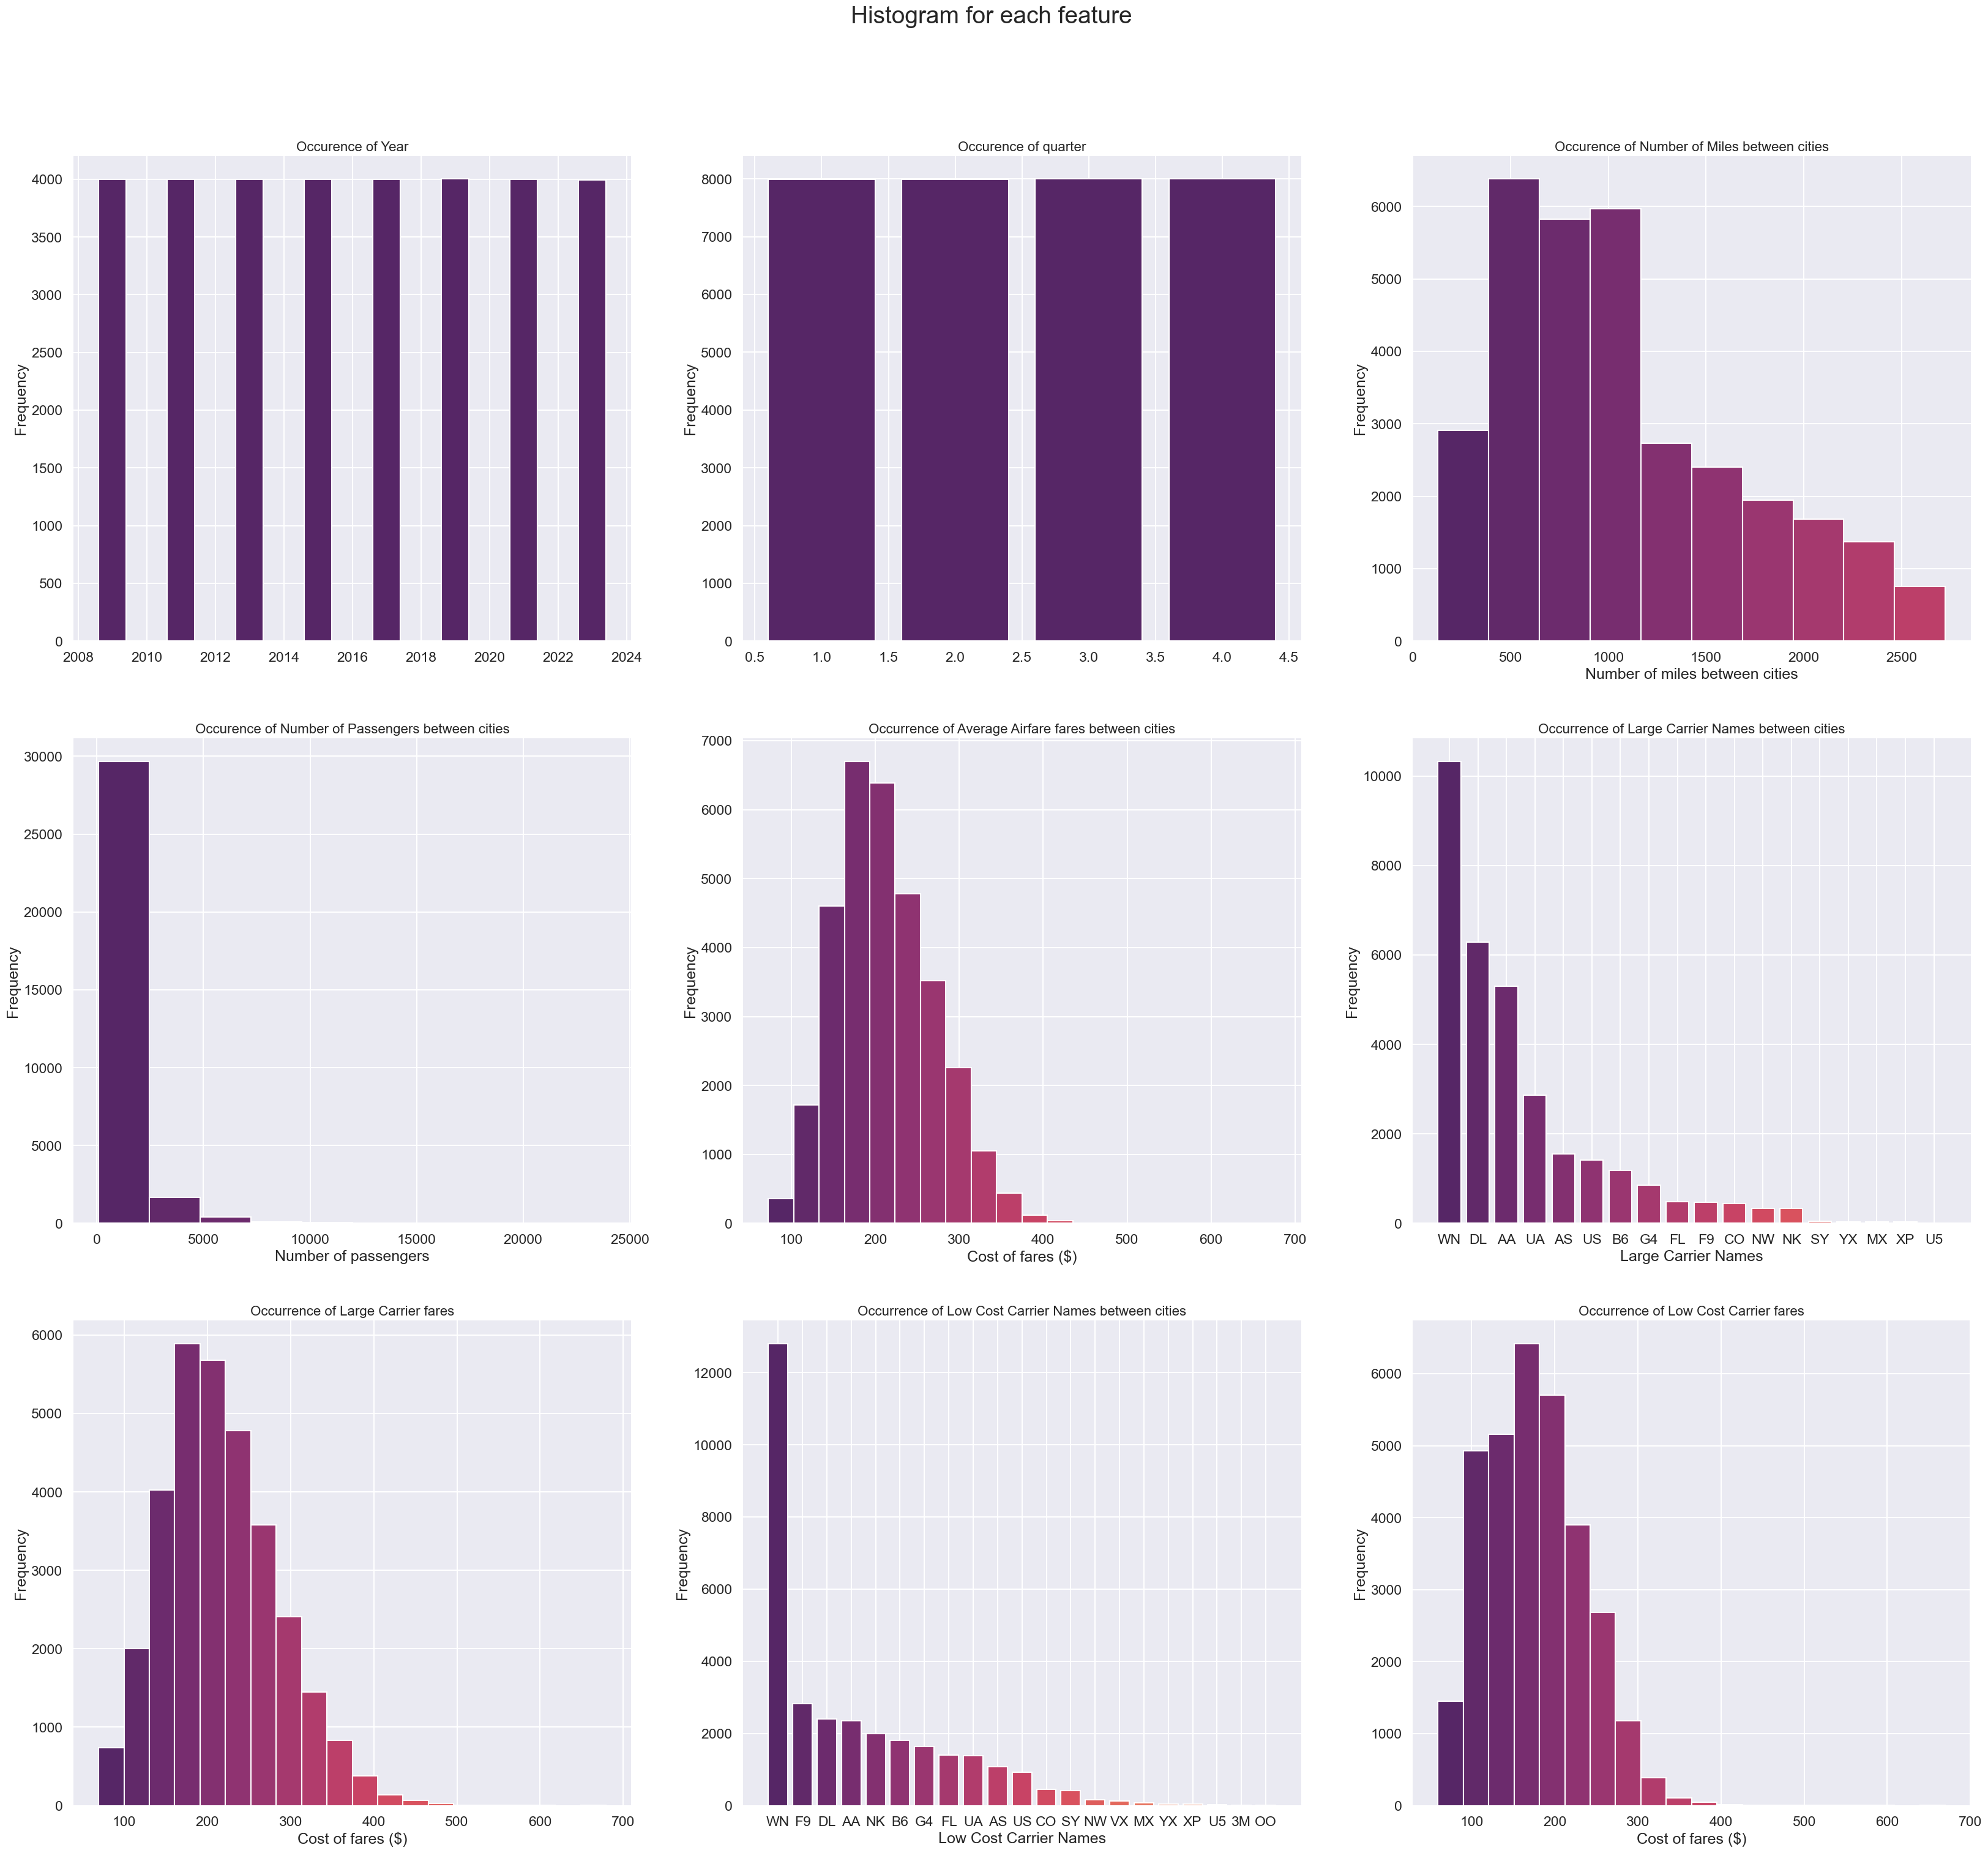

In [1232]:
fig, axs = plt.subplots(3, 3, figsize=(40,35))
fig.suptitle("Histogram for each feature", y=.95, size=28)

year_counts = valid_data["Year"].value_counts()
axs[0, 0].bar(year_counts.index, year_counts.values, edgecolor = "white")
axs[0, 0].set_title("Occurence of Year", fontsize=16)
axs[0, 0].set_ylabel("Frequency")



quarter_counts = valid_data["quarter"].value_counts()
axs[0, 1].bar(quarter_counts.index, quarter_counts.values, edgecolor = "white")
axs[0, 1].set_title("Occurence of quarter", fontsize=16)
axs[0, 1].set_ylabel("Frequency")


counts, bins, patches = axs[0, 2].hist(valid_data["nsmiles"], edgecolor = "white")
axs[0, 2].set_title("Occurence of Number of Miles between cities", fontsize=16)
axs[0, 2].set_xlabel("Number of miles between cities")
axs[0, 2].set_ylabel("Frequency")

# Apply the color palette to the histogram bins
palette = sns.color_palette()
for patch, color in zip(patches, palette):
    patch.set_facecolor(color)

counts, bins, patches = axs[1, 0].hist(valid_data["passengers"], edgecolor = "white")
axs[1, 0].set_title("Occurence of Number of Passengers between cities", fontsize=16)
axs[1, 0].set_xlabel("Number of passengers")
axs[1, 0].set_ylabel("Frequency")

# Apply the color palette to the histogram bins
palette = sns.color_palette()
for patch, color in zip(patches, palette):
    patch.set_facecolor(color)

counts, bins, patches = axs[1, 1].hist(valid_data["fare"], bins=20, edgecolor = "white")
axs[1, 1].set_title("Occurrence of Average Airfare fares between cities", fontsize=16)
axs[1, 1].set_xlabel("Cost of fares ($)")
axs[1, 1].set_ylabel("Frequency")

# Apply the color palette to the histogram bins
palette = sns.color_palette()
for patch, color in zip(patches, palette):
    patch.set_facecolor(color)

carrier_lg_counts = valid_data["carrier_lg"].value_counts()
axs[1, 2].bar(carrier_lg_counts.index, carrier_lg_counts.values, color = sns.color_palette(), edgecolor = "white")
axs[1, 2].set_title("Occurrence of Large Carrier Names between cities", fontsize=16)
axs[1, 2].set_xlabel("Large Carrier Names")
axs[1, 2].set_ylabel("Frequency")


counts, bins, patches = axs[2, 0].hist(valid_data["fare_lg"], bins=20, edgecolor = "white")
axs[2, 0].set_title("Occurrence of Large Carrier fares", fontsize=16)
axs[2, 0].set_xlabel("Cost of fares ($)")
axs[2, 0].set_ylabel("Frequency")

# Apply the color palette to the histogram bins
palette = sns.color_palette()
for patch, color in zip(patches, palette):
    patch.set_facecolor(color)

carrier_low_counts = valid_data["carrier_low"].value_counts()
axs[2, 1].bar(carrier_low_counts.index, carrier_low_counts.values, edgecolor = "white", color = sns.color_palette())
axs[2, 1].set_title("Occurrence of Low Cost Carrier Names between cities", fontsize=16)
axs[2, 1].set_xlabel("Low Cost Carrier Names")
axs[2, 1].set_ylabel("Frequency")

counts, bins, patches = axs[2, 2].hist(valid_data["fare_low"],  bins=20, edgecolor = "white")
axs[2, 2].set_title("Occurrence of Low Cost Carrier fares", fontsize=16)
axs[2, 2].set_xlabel("Cost of fares ($)")
axs[2, 2].set_ylabel("Frequency")

# Apply the color palette to the histogram bins
palette = sns.color_palette()
for patch, color in zip(patches, palette):
    patch.set_facecolor(color)


fig.savefig(save_results_to + "histogram.png", dpi=300)
fig.savefig(save_results_to + "histogram_transparent.png", dpi=300, transparent=True)


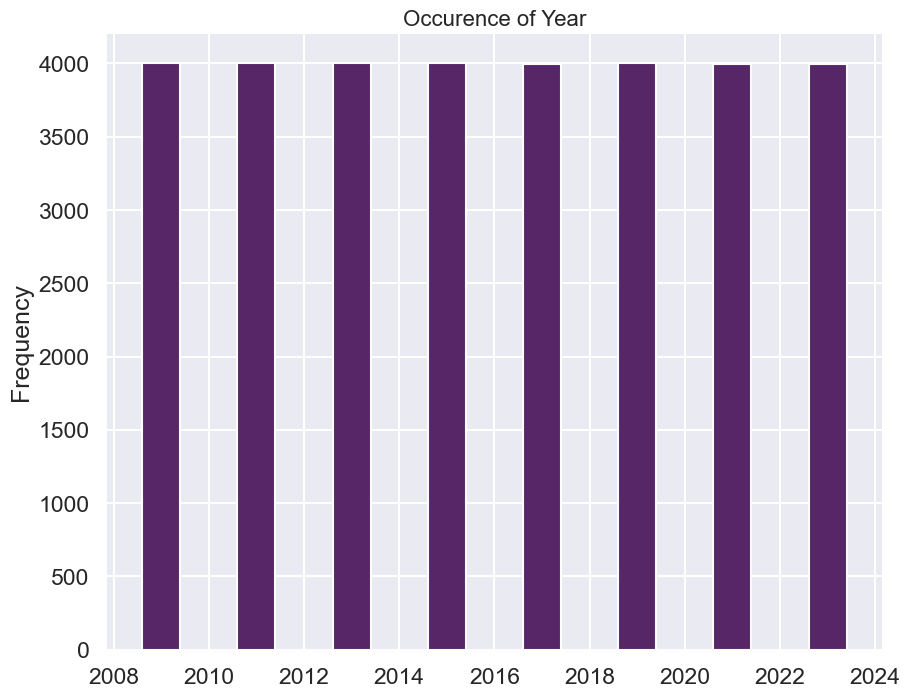

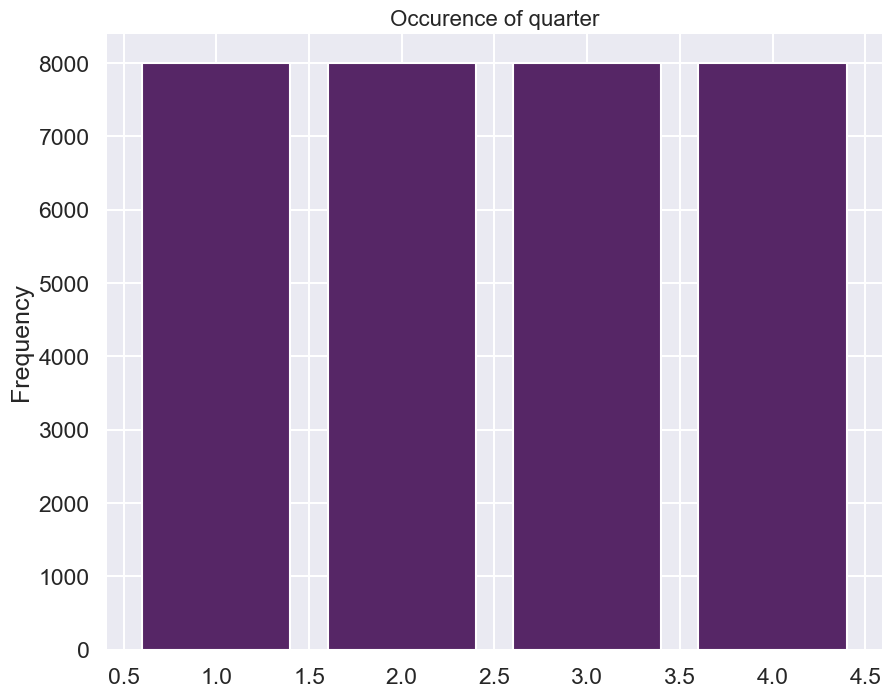

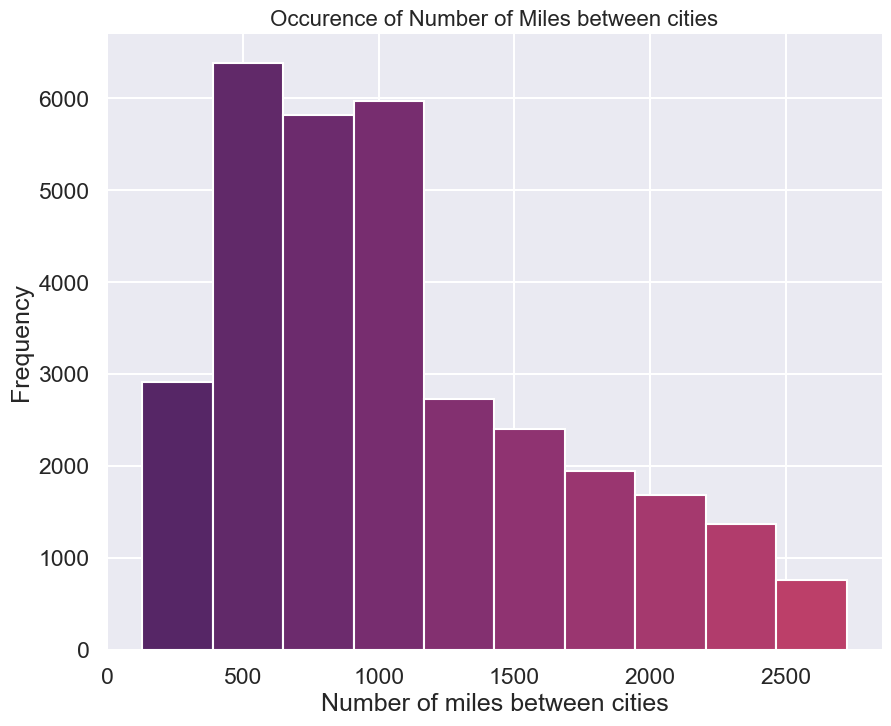

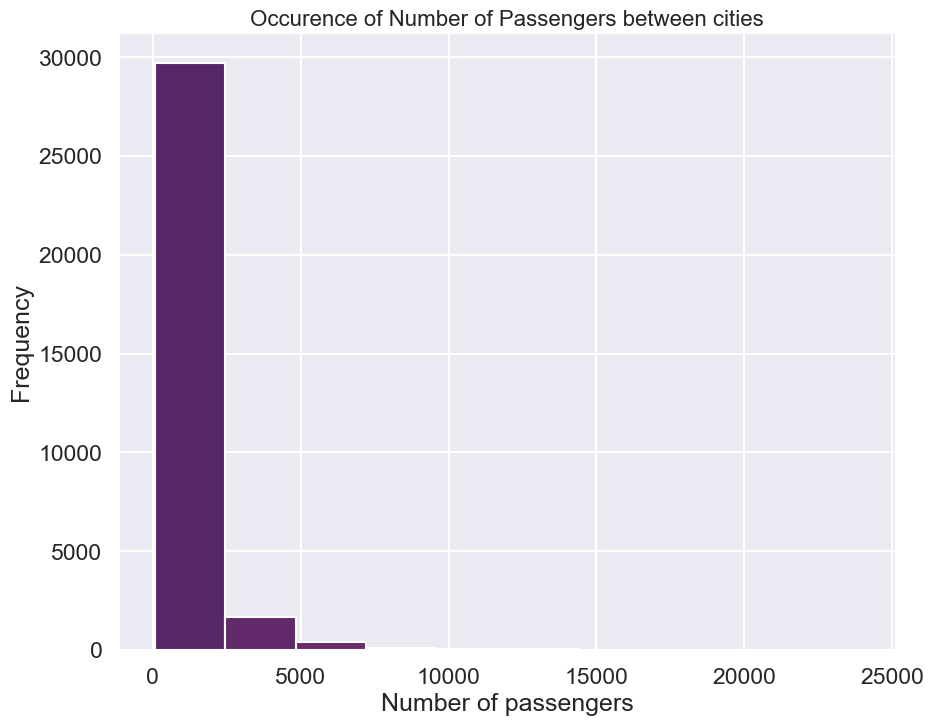

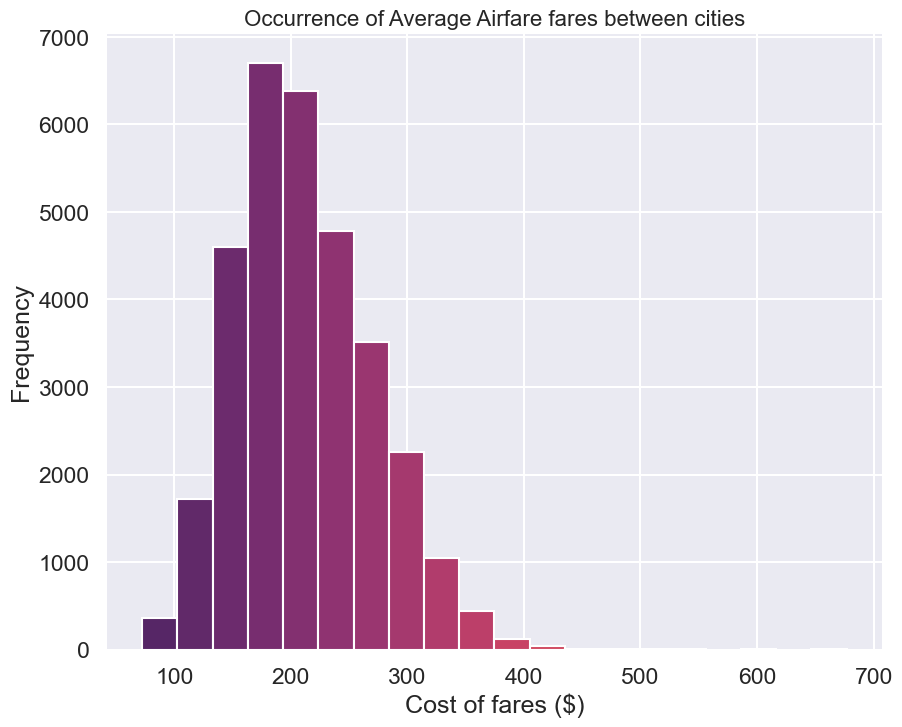

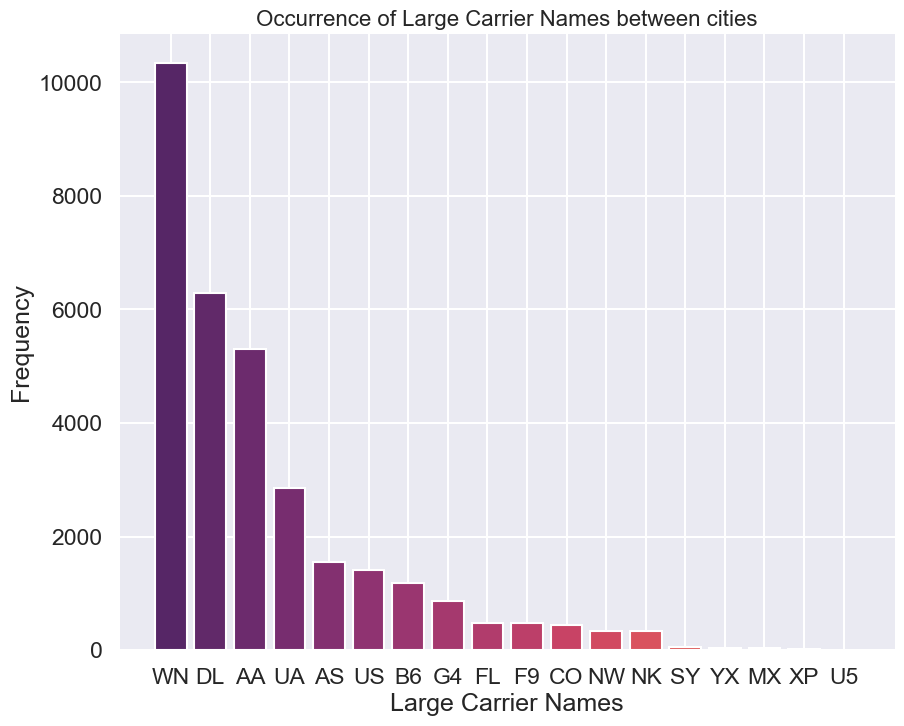

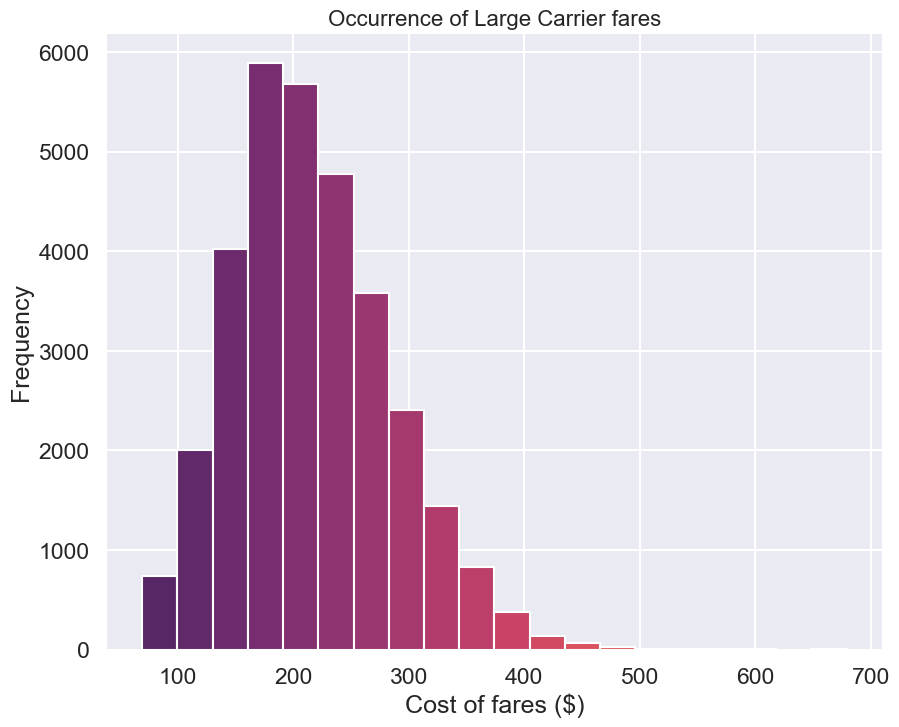

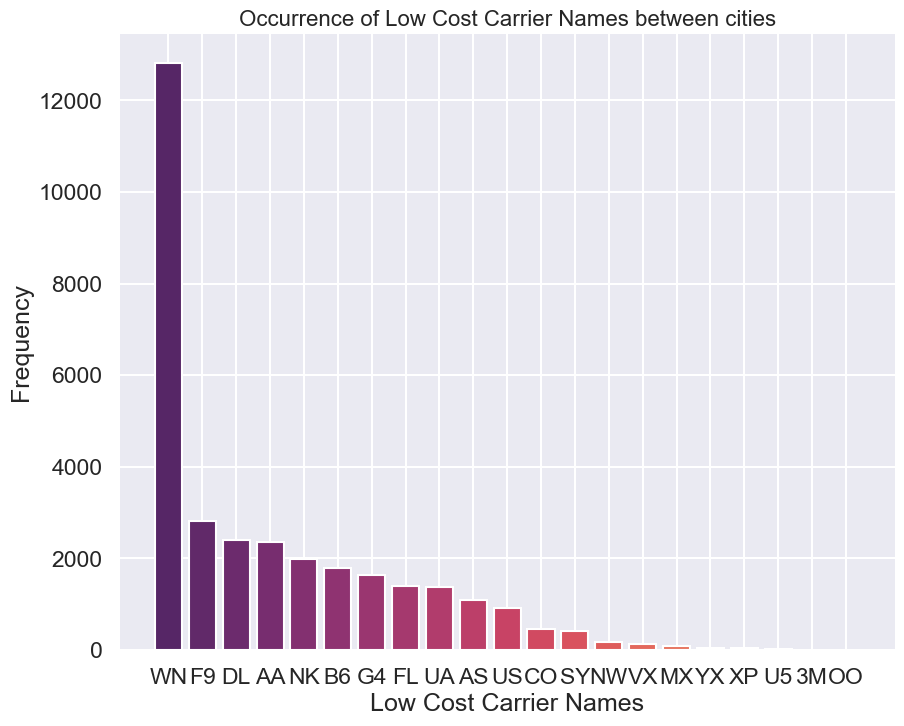

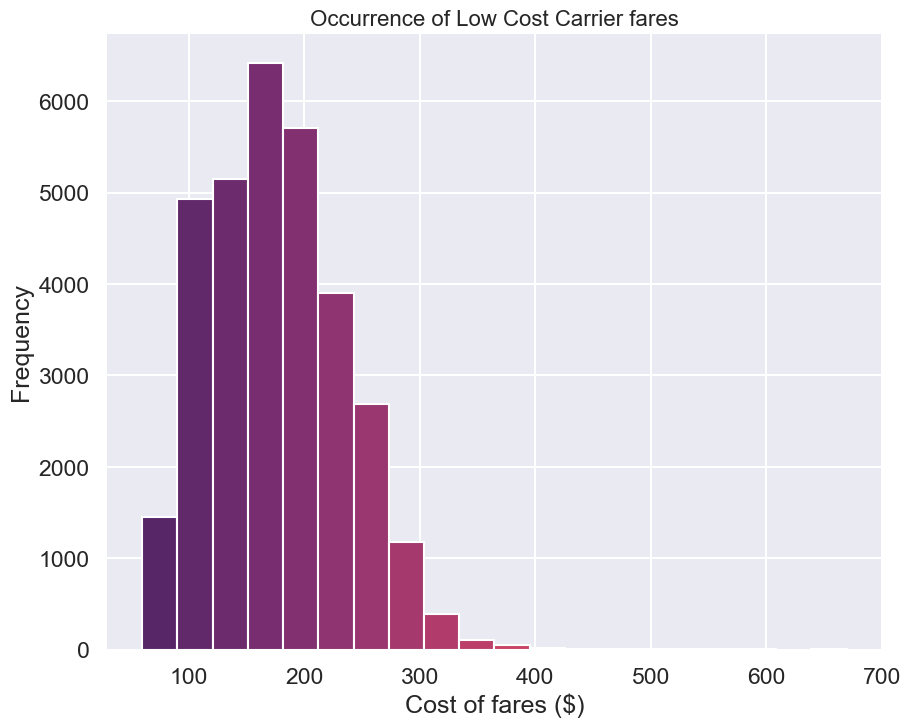

In [1233]:
# Plot 1: Occurence of Year
fig, ax = plt.subplots(figsize=(10, 8))
year_counts = valid_data["Year"].value_counts()
ax.bar(year_counts.index, year_counts.values, edgecolor="white")
ax.set_title("Occurence of Year", fontsize=16)
ax.set_ylabel("Frequency")
fig.savefig(save_results_to + 'plot_year.png', dpi=300, transparent=True)

# Plot 2: Occurence of quarter
fig, ax = plt.subplots(figsize=(10, 8))
quarter_counts = valid_data["quarter"].value_counts()
ax.bar(quarter_counts.index, quarter_counts.values, edgecolor="white")
ax.set_title("Occurence of quarter", fontsize=16)
ax.set_ylabel("Frequency")
fig.savefig(save_results_to + 'plot_quarter.png', dpi=300, transparent=True)

# Plot 3: Occurence of Number of Miles between cities
fig, ax = plt.subplots(figsize=(10, 8))
counts, bins, patches = ax.hist(valid_data["nsmiles"], edgecolor="white")
ax.set_title("Occurence of Number of Miles between cities", fontsize=16)
ax.set_xlabel("Number of miles between cities")
ax.set_ylabel("Frequency")
palette = sns.color_palette()
for patch, color in zip(patches, palette):
    patch.set_facecolor(color)
fig.savefig(save_results_to + 'plot_nsmiles.png', dpi=300, transparent=True)

# Plot 4: Occurence of Number of Passengers between cities
fig, ax = plt.subplots(figsize=(10, 8))
counts, bins, patches = ax.hist(valid_data["passengers"], edgecolor="white")
ax.set_title("Occurence of Number of Passengers between cities", fontsize=16)
ax.set_xlabel("Number of passengers")
ax.set_ylabel("Frequency")
palette = sns.color_palette()
for patch, color in zip(patches, palette):
    patch.set_facecolor(color)
fig.savefig(save_results_to + 'plot_passengers.png', dpi=300, transparent=True)

# Plot 5: Occurrence of Average Airfare fares between cities
fig, ax = plt.subplots(figsize=(10, 8))
counts, bins, patches = ax.hist(valid_data["fare"], bins=20, edgecolor="white")
ax.set_title("Occurrence of Average Airfare fares between cities", fontsize=16)
ax.set_xlabel("Cost of fares ($)")
ax.set_ylabel("Frequency")
palette = sns.color_palette()
for patch, color in zip(patches, palette):
    patch.set_facecolor(color)
fig.savefig(save_results_to + 'plot_fare.png', dpi=300, transparent=True)

# Plot 6: Occurrence of Large Carrier Names between cities
fig, ax = plt.subplots(figsize=(10, 8))
carrier_lg_counts = valid_data["carrier_lg"].value_counts()
ax.bar(carrier_lg_counts.index, carrier_lg_counts.values, color=sns.color_palette(), edgecolor="white")
ax.set_title("Occurrence of Large Carrier Names between cities", fontsize=16)
ax.set_xlabel("Large Carrier Names")
ax.set_ylabel("Frequency")
fig.savefig(save_results_to + 'plot_carrier_lg.png', dpi=300, transparent=True)

# Plot 7: Occurrence of Large Carrier fares
fig, ax = plt.subplots(figsize=(10, 8))
counts, bins, patches = ax.hist(valid_data["fare_lg"], bins=20, edgecolor="white")
ax.set_title("Occurrence of Large Carrier fares", fontsize=16)
ax.set_xlabel("Cost of fares ($)")
ax.set_ylabel("Frequency")
palette = sns.color_palette()
for patch, color in zip(patches, palette):
    patch.set_facecolor(color)
fig.savefig(save_results_to + 'plot_fare_lg.png', dpi=300, transparent=True)

# Plot 8: Occurrence of Low Cost Carrier Names between cities
fig, ax = plt.subplots(figsize=(10, 8))
carrier_low_counts = valid_data["carrier_low"].value_counts()
ax.bar(carrier_low_counts.index, carrier_low_counts.values, edgecolor="white", color=sns.color_palette())
ax.set_title("Occurrence of Low Cost Carrier Names between cities", fontsize=16)
ax.set_xlabel("Low Cost Carrier Names")
ax.set_ylabel("Frequency")
fig.savefig(save_results_to + 'plot_carrier_low.png', dpi=300, transparent=True)

# Plot 9: Occurrence of Low Cost Carrier fares
fig, ax = plt.subplots(figsize=(10, 8))
counts, bins, patches = ax.hist(valid_data["fare_low"], bins=20, edgecolor="white")
ax.set_title("Occurrence of Low Cost Carrier fares", fontsize=16)
ax.set_xlabel("Cost of fares ($)")
ax.set_ylabel("Frequency")
palette = sns.color_palette()
for patch, color in zip(patches, palette):
    patch.set_facecolor(color)
fig.savefig(save_results_to + 'plot_fare_low.png', dpi=300, transparent=True)

In [ ]:
# Plot 4: Occurence of Number of Passengers between cities
fig, ax = plt.subplots(figsize=(10, 8))
counts, bins, patches = ax.hist(valid_data["passengers"], edgecolor="white")
ax.set_title("Occurence of Number of Passengers between cities", fontsize=16)
ax.set_xlabel("Number of passengers")
ax.set_ylabel("Frequency")
palette = sns.color_palette()
for patch, color in zip(patches, palette):
    patch.set_facecolor(color)
fig.savefig(save_results_to + 'plot_passengers.png', dpi=300, transparent=True)

We can see that the data has very uniform year and quarter features, while most other features are right skewed. This makes me think that I should use normalization instead of standardization to scale these features, because we can't assume a normal distribution for most features.

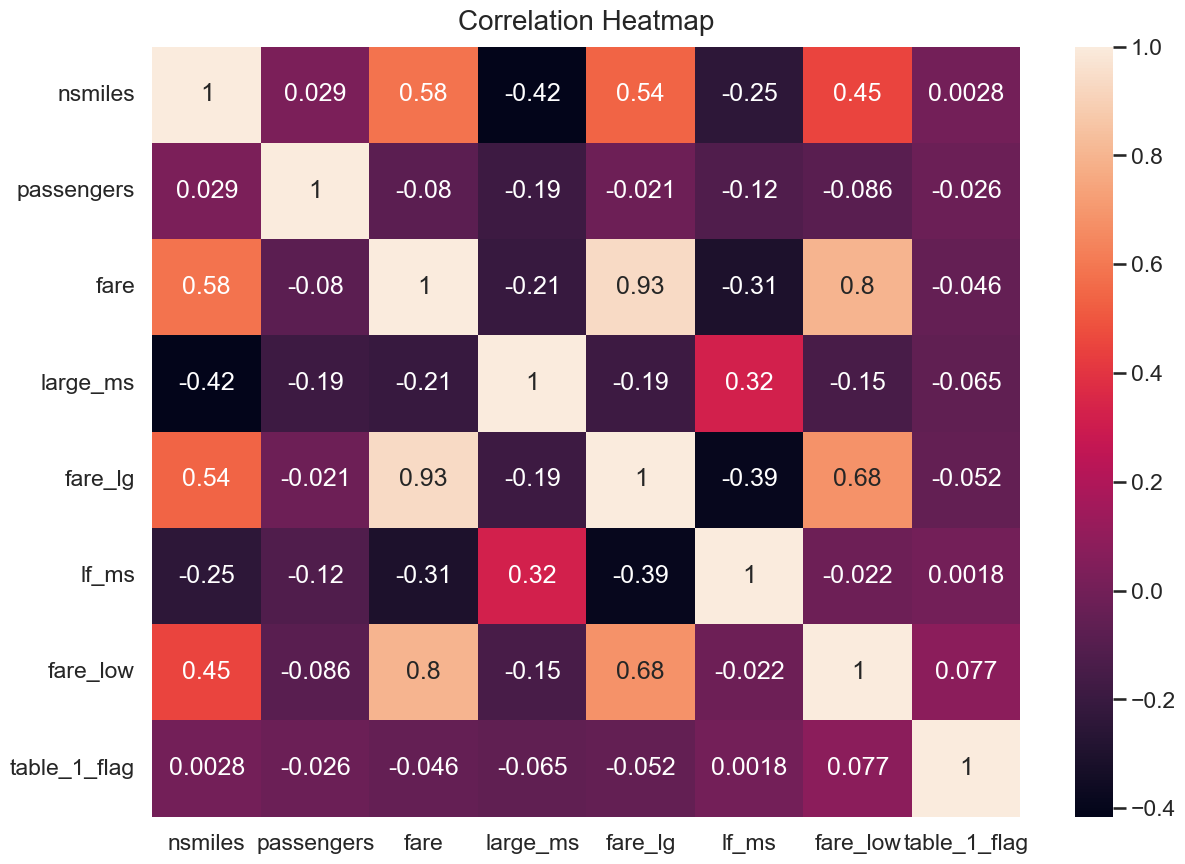

In [1234]:
corr_df = valid_data.drop(["Year", "quarter", "city1", "city2", "citymarketid_1", "citymarketid_2", "carrier_lg", "carrier_low", "Geocoded_City1", "Geocoded_City2"], axis="columns")


plt.figure(figsize=(14, 10))
heatmap = sns.heatmap(corr_df.corr(), annot=True)
heatmap.set_title('Correlation Heatmap', fontsize=20, pad=12)

plt.savefig(save_results_to + 'heatmap.png', dpi=300)
plt.savefig(save_results_to + 'heatmap_transparent.png', dpi=300, transparent=True)

In [1235]:
routes = set(zip(valid_data.citymarketid_1,valid_data.citymarketid_2))
print("There are a total of", len(routes), "unique routes in this dataset")

city_id = pd.concat([valid_data["citymarketid_1"], valid_data["citymarketid_2"]]).drop_duplicates().reset_index(drop=True)
print("There are a total of", city_id.size, "unique cities in the dataset")


There are a total of 1510 unique routes in this dataset
There are a total of 163 unique cities in the dataset


In [1319]:
large_carriers = valid_data["carrier_lg"].drop_duplicates().reset_index(drop=True)
print("There are a total of", large_carriers.size, "unique large carriers in the dataset")

low_cost_carriers = valid_data["carrier_low"].drop_duplicates().reset_index(drop=True)
print("There are a total of", low_cost_carriers.size, "unique low cost carriers in the dataset")

large_and_low_cost_carriers = pd.concat([valid_data["carrier_lg"], valid_data["carrier_low"]]).drop_duplicates().reset_index(drop=True)
print("There are a total of", large_and_low_cost_carriers.size, "unique large and low cost carriers in the dataset")

exclusive_lowcost = pd.concat([large_carriers, low_cost_carriers]).drop_duplicates(keep=False)
display(exclusive_lowcost)
display(large_carriers)

There are a total of 18 unique large carriers in the dataset
There are a total of 21 unique low cost carriers in the dataset
There are a total of 21 unique large and low cost carriers in the dataset


15    VX
17    OO
18    3M
dtype: object

0     FL
1     AA
2     WN
3     UA
4     DL
5     CO
6     G4
7     US
8     NW
9     NK
10    F9
11    B6
12    AS
13    U5
14    SY
15    YX
16    MX
17    XP
Name: carrier_lg, dtype: category
Categories (18, object): ['AA', 'AS', 'B6', 'CO', ..., 'US', 'WN', 'XP', 'YX']

In [1237]:
airline_occurrences = {}
def countAirlineOccurrences(carrier_lg, carrier_low, large_ms, lf_ms):
        if large_ms > lf_ms:
            airline_occurrences[carrier_lg] = airline_occurrences.get(carrier_lg, 0) + 1
        elif large_ms < lf_ms:
            airline_occurrences[carrier_low] = airline_occurrences.get(carrier_low, 0) + 1
        else:
            if carrier_lg == carrier_low:
                # doesn't matter
                airline_occurrences[carrier_low] = airline_occurrences.get(carrier_low, 0) + 1
            else:
                # put both
                airline_occurrences[carrier_lg] = airline_occurrences.get(carrier_lg, 0) + 1
                airline_occurrences[carrier_low] = airline_occurrences.get(carrier_low, 0) + 1


result = [countAirlineOccurrences(row[0], row[1], row[2], row[3]) for row in zip(data['carrier_lg'], data['carrier_low'], data['large_ms'], data['lf_ms'])]
print(airline_occurrences)

{'FL': 486, 'AA': 5307, 'WN': 10352, 'UA': 2867, 'DL': 6295, 'CO': 453, 'G4': 861, 'US': 1411, 'NW': 341, 'NK': 331, 'F9': 476, 'B6': 1189, 'AS': 1553, 'U5': 4, 'SY': 46, 'YX': 35, 'MX': 36, 'XP': 27}


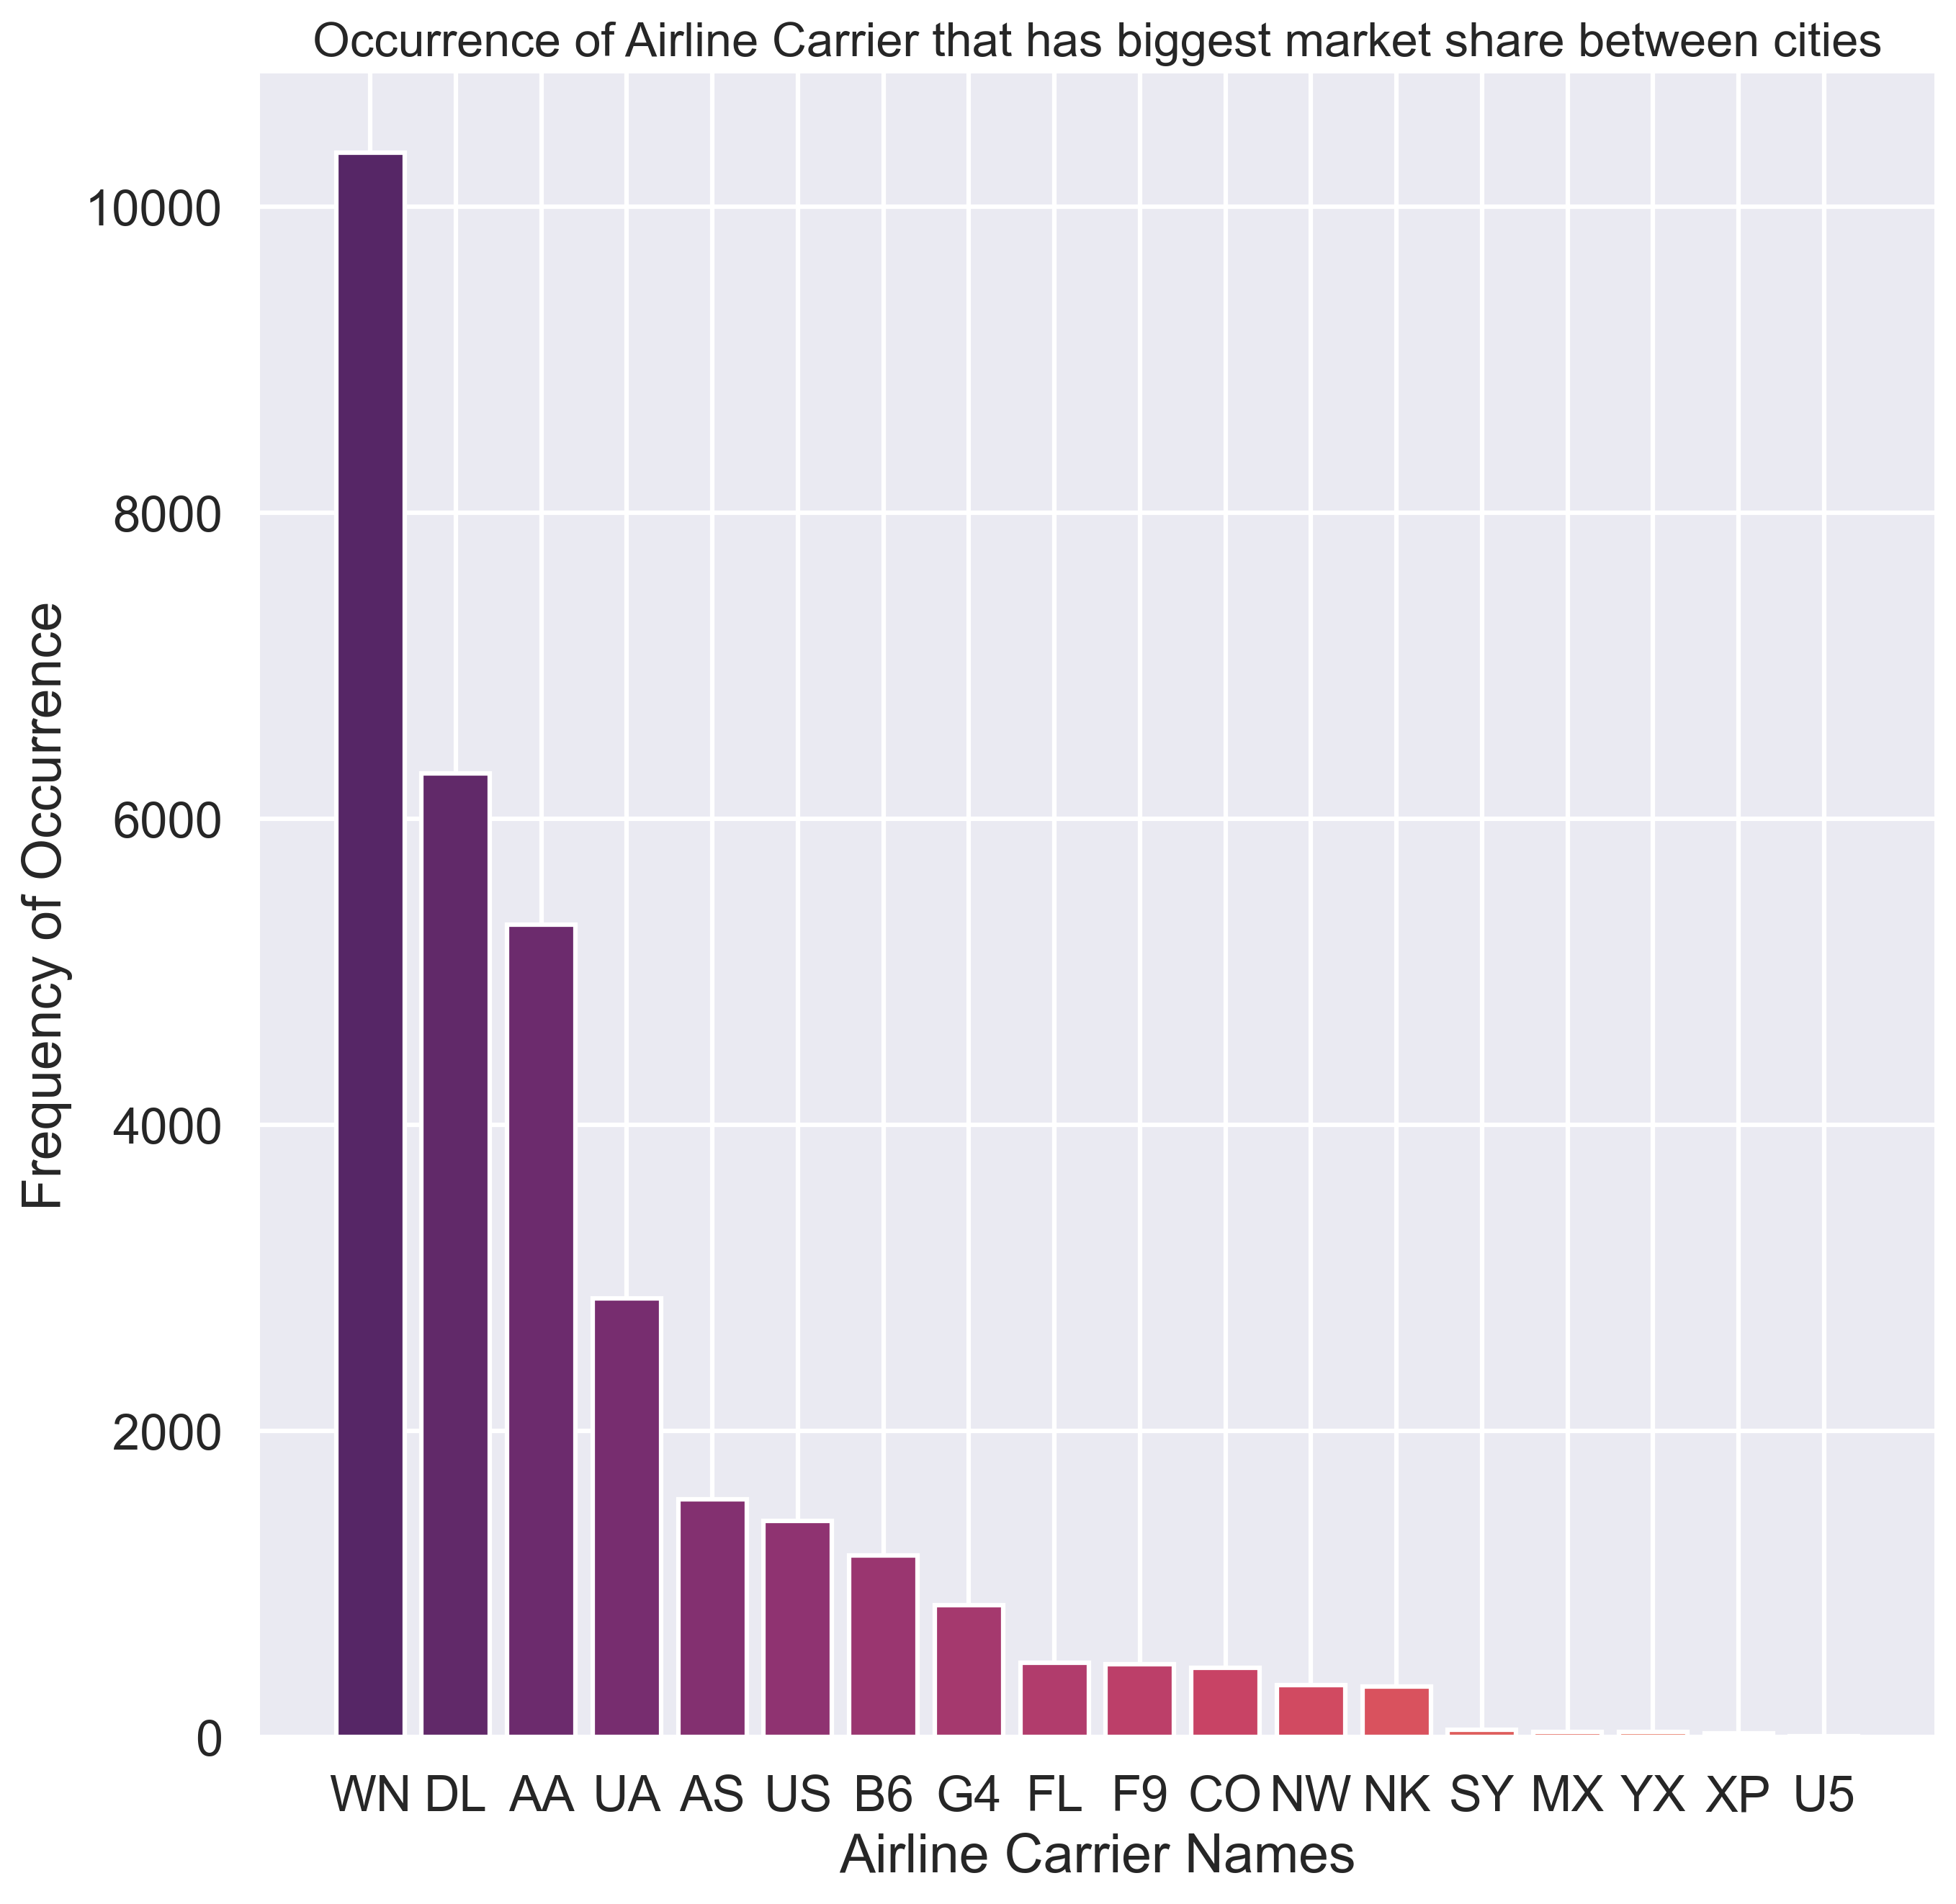

In [1238]:
airline_occ_df = pd.DataFrame.from_dict(airline_occurrences, orient='index', columns=['Frequency'])
airline_occ_df.sort_values("Frequency", ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,10))
fig.dpi = 300
# fig.suptitle("Histogram for each feature", y=.95, size=28)
ax.bar(airline_occ_df.index, airline_occ_df["Frequency"], color = sns.color_palette())
ax.set_title("Occurrence of Airline Carrier that has biggest market share between cities", fontsize=16)
ax.set_xlabel("Airline Carrier Names")
ax.set_ylabel("Frequency of Occurrence")

fig.savefig(save_results_to + "histogram_market_share.png", dpi=300)
fig.savefig(save_results_to + "histogram_market_share_transparent.png", dpi=300, transparent=True)

In [1239]:
high_volume_routes = valid_data[valid_data["passengers"] > 5000]
high_volume_routes.count()

Year              613
quarter           613
citymarketid_1    613
citymarketid_2    613
city1             613
city2             613
nsmiles           613
passengers        613
fare              613
carrier_lg        613
large_ms          613
fare_lg           613
carrier_low       613
lf_ms             613
fare_low          613
table_1_flag      613
Geocoded_City1    421
Geocoded_City2    421
dtype: int64

In [1240]:
high_volume_routes.describe()

,nsmiles,passengers,fare,large_ms,fare_lg,lf_ms,fare_low
count,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000
mean,1030.040783,8039.254486,192.133067,0.462292,202.154290,0.245928,162.539429
std,682.651288,3792.862802,68.818646,0.154312,83.341328,0.168164,53.045056
min,236.000000,5005.000000,96.380000,0.150000,96.140000,0.022500,78.450000
25%,447.000000,5568.000000,147.050000,0.330000,146.580000,0.128400,127.940000
50%,862.000000,6417.000000,171.990000,0.453900,174.720000,0.181600,152.630000
75%,1139.000000,8983.000000,212.330000,0.581100,226.370000,0.303100,181.180000
max,2619.000000,23884.000000,428.610000,0.917600,559.850000,0.917600,369.210000


In [1241]:
# What route carries the max number of passengers and how many?

max_passenger_index = high_volume_routes["passengers"].idxmax()
high_volume_routes.loc[max_passenger_index]

Year                                               2019
quarter                                               4
citymarketid_1                                    32575
citymarketid_2                                    32457
city1               Los Angeles, CA (Metropolitan Area)
city2             San Francisco, CA (Metropolitan Area)
nsmiles                                             372
passengers                                        23884
fare                                             135.66
carrier_lg                                           WN
large_ms                                         0.5917
fare_lg                                          134.19
carrier_low                                          AS
lf_ms                                            0.1399
fare_low                                         121.29
table_1_flag                                         -1
Geocoded_City1                                      NaN
Geocoded_City2                                  

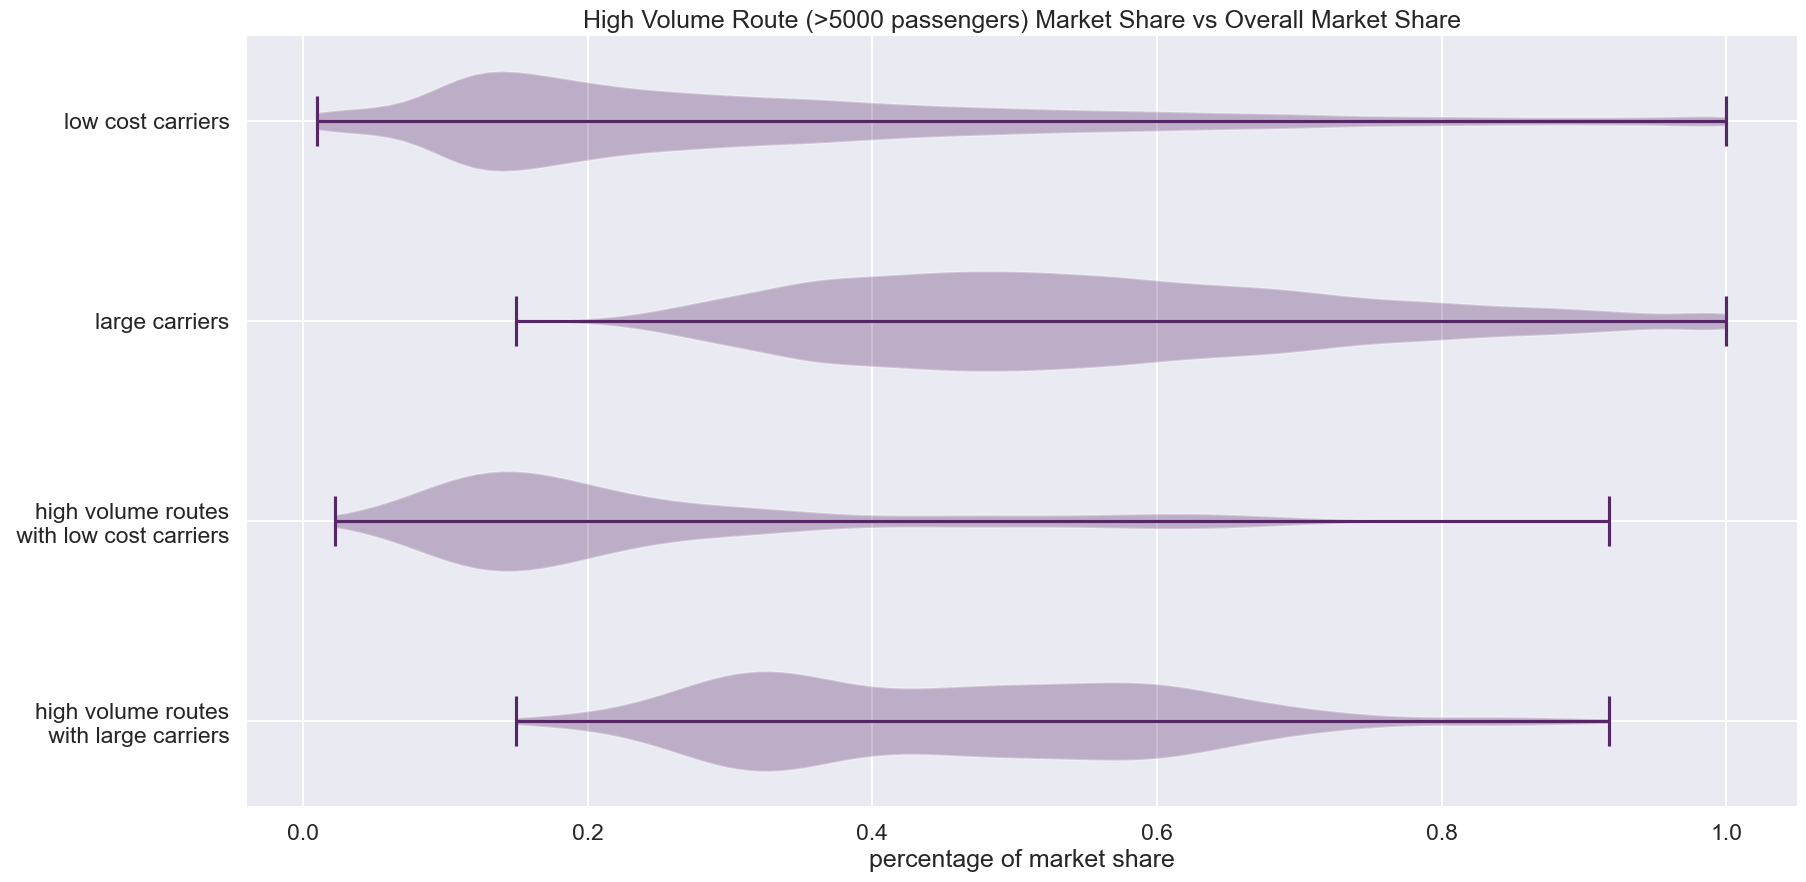

In [1242]:
fig, ax = plt.subplots(figsize=(20,10))

labels = ['high volume routes\n with large carriers', 'high volume routes\n with low cost carriers', 'large carriers', 'low cost carriers']
hv_combined_data = [high_volume_routes["large_ms"], high_volume_routes["lf_ms"], valid_data["large_ms"], valid_data["lf_ms"]]
ax.violinplot(hv_combined_data, vert=False)
ax.set_title("High Volume Route (>5000 passengers) Market Share vs Overall Market Share")
ax.set_yticks([y + 1 for y in range(len(hv_combined_data))], labels=labels)

ax.set_xlabel("percentage of market share")

fig.savefig(save_results_to + "violin_ms.png",dpi=300)
fig.savefig(save_results_to + "violin_ms_tp.png",dpi=300, transparent=True)

plt.show()

In [1243]:
routes = set(zip(high_volume_routes.citymarketid_1,high_volume_routes.citymarketid_2))
print("There are a total of", len(routes), "unique high volume routes in this dataset")

city_id = pd.concat([high_volume_routes["citymarketid_1"], high_volume_routes["citymarketid_2"]]).drop_duplicates().reset_index(drop=True)
print("There are a total of", city_id.size, "unique high volume cities in the dataset")

There are a total of 37 unique high volume routes in this dataset
There are a total of 20 unique high volume cities in the dataset


In [1244]:
# Get routes that are not run by the same airline carrier and routes that do not have equal market share
competitive_routes = valid_data.loc[(valid_data["carrier_lg"].astype(str) != valid_data["carrier_low"].astype(str)) & (valid_data["large_ms"] != valid_data["lf_ms"])]
competitive_routes.count()

Year              21410
quarter           21410
citymarketid_1    21410
citymarketid_2    21410
city1             21410
city2             21410
nsmiles           21410
passengers        21410
fare              21410
carrier_lg        21410
large_ms          21410
fare_lg           21410
carrier_low       21410
lf_ms             21410
fare_low          21410
table_1_flag      21410
Geocoded_City1    14659
Geocoded_City2    14659
dtype: int64

In [1245]:
# Returns number of rows that are True if large carriers have more market share than low cost carriers otherwise False
large_ms_dominance = competitive_routes["large_ms"] > competitive_routes["lf_ms"]
large_ms_dominance.value_counts()

True    21410
Name: count, dtype: int64

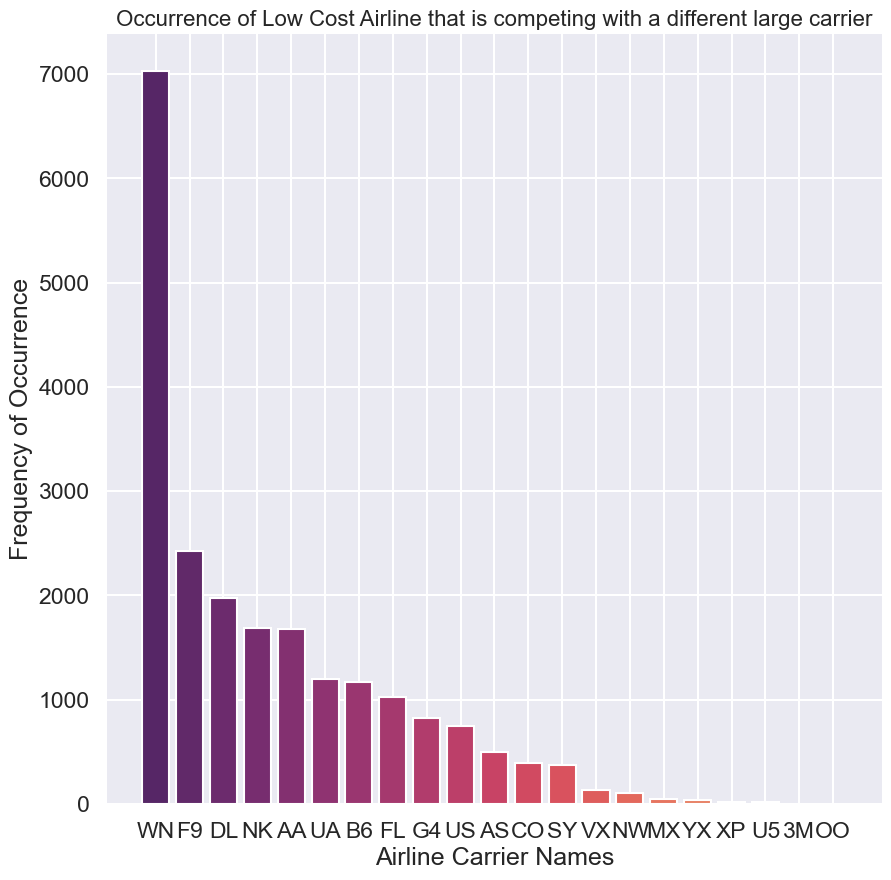

In [1246]:
comp_carrier_low_counts = competitive_routes["carrier_low"].value_counts()


fig, ax = plt.subplots(figsize=(10,10))
# fig.suptitle("Histogram for each feature", y=.95, size=28)
ax.bar(comp_carrier_low_counts.index, comp_carrier_low_counts.values, color = sns.color_palette())
ax.set_title("Occurrence of Low Cost Airline that is competing with a different large carrier", fontsize=16)
ax.set_xlabel("Airline Carrier Names")
ax.set_ylabel("Frequency of Occurrence")

fig.savefig(save_results_to + "histogram_comp_lowcost.png", dpi=300)
fig.savefig(save_results_to + "histogram_comp_lowcost_transparent.png", dpi=300, transparent=True)

## Data Preperation and Feature Engineering

We will be preparing 2 datasets.

One will have all the data
Another one will focus competitive routes (i.e. when the largest market share large carrier and largest market share small carrier on the same route are not the same)

In [1247]:
print(valid_data.dtypes)

Year              category
quarter           category
citymarketid_1    category
citymarketid_2    category
city1               object
city2               object
nsmiles              int64
passengers           int64
fare               float64
carrier_lg        category
large_ms           float64
fare_lg            float64
carrier_low       category
lf_ms              float64
fare_low           float64
table_1_flag      category
Geocoded_City1      object
Geocoded_City2      object
dtype: object


To prepare the data to put into our models, we need to encode categorical variables and standardize the continuous variables.

The ```Year``` variables will be used as our index to train test split the data.

```Quarter``` will be dummy encoded.

We need a way to smartly encode the routes information to feed into our models. There are 1338 unique routes and 133 unique cities in our dataset.
- If we were to one hot encode the routes, we would add 1338 more features to our dataset which is too much dimensionality
- If we were to one hot encode the cities, both departing and arriving, we would have to add 266 more features which is a lot but still less than encoding the total number of routes.

We also need a way to encode the carrier information for both large and low cost airlines. There are a total of 18 unique large carriers and a total of 21 unique low cost carriers carriers.

We can dummy encode the ```table_1_flag``` information which represents that the route is part of the top 1,000 contiguous state city-pair markets.

We drop the Geocoded Location information for simplicity as we already have city information


### Dataset 1

In [1248]:
model_data = valid_data.drop(["Year", "city1", "city2", "nsmiles", "Geocoded_City1", "Geocoded_City2", "fare_low", "fare_lg"], axis="columns")

In [1249]:
print(model_data.dtypes)

quarter           category
citymarketid_1    category
citymarketid_2    category
passengers           int64
fare               float64
carrier_lg        category
large_ms           float64
carrier_low       category
lf_ms              float64
table_1_flag      category
dtype: object


In [1250]:
model_data_dummies= pd.get_dummies(model_data)

In [1251]:
model_data_dummies

,passengers,fare,large_ms,lf_ms,quarter_1,quarter_2,quarter_3,quarter_4,citymarketid_1_30135,citymarketid_1_30140,...,carrier_low_SY,carrier_low_U5,carrier_low_UA,carrier_low_US,carrier_low_VX,carrier_low_WN,carrier_low_XP,carrier_low_YX,table_1_flag_-1,table_1_flag_1
0,203,151.46,0.2900,0.2900,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,1224,200.95,0.3200,0.1300,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,294,174.63,0.6600,0.2100,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
3,347,169.72,0.6100,0.2500,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,700,244.01,0.4600,0.2200,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32006,339,227.32,0.7207,0.7207,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
32007,420,248.08,0.4319,0.2761,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
32008,347,180.17,0.6374,0.6374,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
32009,295,143.43,0.8036,0.8036,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False


In [1252]:
print(model_data_dummies.columns)

Index(['passengers', 'fare', 'large_ms', 'lf_ms', 'quarter_1', 'quarter_2',
       'quarter_3', 'quarter_4', 'citymarketid_1_30135',
       'citymarketid_1_30140',
       ...
       'carrier_low_SY', 'carrier_low_U5', 'carrier_low_UA', 'carrier_low_US',
       'carrier_low_VX', 'carrier_low_WN', 'carrier_low_XP', 'carrier_low_YX',
       'table_1_flag_-1', 'table_1_flag_1'],
      dtype='object', length=317)


In [1253]:
# Bring back Year column to dummies dataframe to train test split into
model_data_ttsplit = model_data_dummies.merge(valid_data["Year"], left_index=True, right_index=True)

In [1254]:
print(model_data_ttsplit["Year"].cat.categories)
print(model_data_ttsplit.shape)

Index([2009, 2011, 2013, 2015, 2017, 2019, 2021, 2023], dtype='int64')
(31995, 318)


In [1255]:
X = model_data_ttsplit.drop("fare", axis=1)
y = model_data_ttsplit["fare"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=X["Year"])

In [1256]:
X_train.drop("Year", axis=1, inplace=True)
X_test.drop("Year", axis=1, inplace=True)

In [1257]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(25596, 316)
(6399, 316)
(25596,)
(6399,)


In [1258]:
# Scale features using Normalization
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

### Dataset 2 (Competitive Routes)

In [1259]:
display(competitive_routes)

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,table_1_flag,Geocoded_City1,Geocoded_City2
1,2009,2,32211,32467,"Las Vegas, NV","Miami, FL (Metropolitan Area)",2175,1224,200.95,AA,0.3200,227.52,NK,0.1300,134.62,1,"Las Vegas, NV\n(36.169202, -115.140597)","Miami, FL (Metropolitan Area)\n(44.977479, -93..."
2,2011,4,33044,33195,"Louisville, KY","Tampa, FL (Metropolitan Area)",727,294,174.63,WN,0.6600,173.66,DL,0.2100,166.94,1,"Louisville, KY\n(38.256078, -85.751569)","Tampa, FL (Metropolitan Area)\n(37.8606, -78.8..."
3,2009,2,30977,34524,"Chicago, IL","Richmond, VA",642,347,169.72,UA,0.6100,170.57,AA,0.2500,159.66,1,"Chicago, IL\n(41.775002, -87.696388)","Richmond, VA\n(37.540759, -77.433932)"
4,2013,2,31650,33570,"Minneapolis/St. Paul, MN","San Diego, CA",1532,700,244.01,DL,0.4600,279.09,SY,0.2200,189.26,1,"Minneapolis/St. Paul, MN\n(44.977479, -93.264346)","San Diego, CA\n(32.71576, -117.163817)"
5,2009,3,31453,34492,"Houston, TX","Raleigh/Durham, NC",1050,346,208.70,CO,0.4800,225.96,US,0.1400,184.61,1,"Houston, TX\n(29.760803, -95.369506)","Raleigh/Durham, NC\n(42.673348, -72.179683)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32001,2023,4,34614,33570,"Salt Lake City, UT","San Diego, CA",626,882,224.84,DL,0.6639,242.77,WN,0.2487,184.48,-1,NaN,NaN
32003,2023,4,34986,30852,"Sarasota/Bradenton, FL","Washington, DC (Metropolitan Area)",880,735,202.40,WN,0.4766,206.70,G4,0.1054,98.81,-1,NaN,NaN
32004,2023,4,35096,30852,"Syracuse, NY","Washington, DC (Metropolitan Area)",298,301,211.08,AA,0.4731,230.29,WN,0.2858,178.28,-1,NaN,NaN
32005,2023,4,35096,33195,"Syracuse, NY","Tampa, FL (Metropolitan Area)",1111,334,146.64,G4,0.3438,109.21,MX,0.1921,100.36,-1,NaN,NaN


In [1260]:
cr_data = competitive_routes.drop(["Year", "city1", "city2", "fare", "Geocoded_City1", "Geocoded_City2"], axis="columns")

In [1261]:
# Apply a small constant to zeroes so that log wont go to -inf
# log term mitigates heteroskedasticity

# def addRelativeTerm(X):
#     high_low_rd = np.abs(X["fare_lg"] - X["fare_low"])
#     s = high_low_rd.copy()
#     s[high_low_rd == 0] += 0.001
#     X_dropped = X.drop(["fare_lg", "fare_low"], axis="columns")
#     X_dropped["delta"] = s.apply(np.log)
#     return X_dropped

# cr_X_train = addRelativeTerm(cr_X_train)
# cr_X_test = addRelativeTerm(cr_X_test)

delta = cr_data["fare_lg"] - cr_data["fare_low"]
s = delta.copy()
s[delta == 0] += 0.001
cr_data.drop(["fare_lg", "fare_low"], axis="columns", inplace=True)
cr_data["delta"] = s.apply(np.log)

In [1262]:
print(cr_data.dtypes)

quarter           category
citymarketid_1    category
citymarketid_2    category
nsmiles              int64
passengers           int64
carrier_lg        category
large_ms           float64
carrier_low       category
lf_ms              float64
table_1_flag      category
delta              float64
dtype: object


In [1263]:
cr_data

,quarter,citymarketid_1,citymarketid_2,nsmiles,passengers,carrier_lg,large_ms,carrier_low,lf_ms,table_1_flag,delta
1,2,32211,32467,2175,1224,AA,0.3200,NK,0.1300,1,4.531524
2,4,33044,33195,727,294,WN,0.6600,DL,0.2100,1,1.905088
3,2,30977,34524,642,347,UA,0.6100,AA,0.2500,1,2.389680
4,2,31650,33570,1532,700,DL,0.4600,SY,0.2200,1,4.497919
5,3,31453,34492,1050,346,CO,0.4800,US,0.1400,1,3.722072
...,...,...,...,...,...,...,...,...,...,...,...
32001,4,34614,33570,626,882,DL,0.6639,WN,0.2487,-1,4.065431
32003,4,34986,30852,880,735,WN,0.4766,G4,0.1054,-1,4.681112
32004,4,35096,30852,298,301,AA,0.4731,WN,0.2858,-1,3.951436
32005,4,35096,33195,1111,334,G4,0.3438,MX,0.1921,-1,2.180417


In [1264]:
cr_data_dummies= pd.get_dummies(cr_data)

In [1265]:
cr_data_dummies

,nsmiles,passengers,large_ms,lf_ms,delta,quarter_1,quarter_2,quarter_3,quarter_4,citymarketid_1_30135,...,carrier_low_SY,carrier_low_U5,carrier_low_UA,carrier_low_US,carrier_low_VX,carrier_low_WN,carrier_low_XP,carrier_low_YX,table_1_flag_-1,table_1_flag_1
1,2175,1224,0.3200,0.1300,4.531524,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,727,294,0.6600,0.2100,1.905088,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
3,642,347,0.6100,0.2500,2.389680,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,1532,700,0.4600,0.2200,4.497919,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True
5,1050,346,0.4800,0.1400,3.722072,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32001,626,882,0.6639,0.2487,4.065431,False,False,False,True,False,...,False,False,False,False,False,True,False,False,True,False
32003,880,735,0.4766,0.1054,4.681112,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
32004,298,301,0.4731,0.2858,3.951436,False,False,False,True,False,...,False,False,False,False,False,True,False,False,True,False
32005,1111,334,0.3438,0.1921,2.180417,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False


In [1266]:
# Bring back Year column to dummies dataframe to train test split into
cr_data_ttsplit = cr_data_dummies.merge(competitive_routes["Year"], left_index=True, right_index=True)

In [1267]:
X = cr_data_ttsplit.drop("delta", axis=1)
y = cr_data_ttsplit["delta"]

cr_X_train, cr_X_test, cr_y_train, cr_y_test = train_test_split(X, y, test_size=.2, stratify=X["Year"])

In [1268]:
cr_X_train.drop("Year", axis=1, inplace=True)
cr_X_test.drop("Year", axis=1, inplace=True)

In [1269]:
print(cr_X_train.shape)
print(cr_X_test.shape)
print(cr_y_train.shape)
print(cr_y_test.shape)

(17128, 317)
(4282, 317)
(17128,)
(4282,)


In [1270]:
# Scale features using Normalization
scaler = MinMaxScaler()
cr_X_train_normalized = scaler.fit_transform(cr_X_train)
cr_X_test_normalized = scaler.transform(cr_X_test)

In [1271]:
cr_X_train

,nsmiles,passengers,large_ms,lf_ms,quarter_1,quarter_2,quarter_3,quarter_4,citymarketid_1_30135,citymarketid_1_30140,...,carrier_low_SY,carrier_low_U5,carrier_low_UA,carrier_low_US,carrier_low_VX,carrier_low_WN,carrier_low_XP,carrier_low_YX,table_1_flag_-1,table_1_flag_1
17911,1865,1028,0.4730,0.2616,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
14789,1846,1155,0.4218,0.1790,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
12767,650,189,0.5766,0.3399,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
5255,834,1307,0.4500,0.4100,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
13367,1276,2089,0.3517,0.1555,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27769,840,775,0.5328,0.1188,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2117,1444,2295,0.3300,0.2500,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
31582,854,2532,0.3480,0.1074,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
3204,1013,2355,0.4700,0.2900,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True


Just a quick EDA to see how many times market share of larger airlines is greater than low cost ones

In [1272]:
cr_data["large_ms_dominance"] = cr_data["large_ms"] > cr_data["lf_ms"]
cr_data["large_ms_dominance"].value_counts()

large_ms_dominance
True    21410
Name: count, dtype: int64

## Model Creation

### Experiment 1

#### Random Forest 1

First we will create a Random Forest Model

In [1273]:
rf_model = RandomForestRegressor(n_estimators=100)

rf_model.fit(X_train, y_train)


RandomForestRegressor()

In [1274]:
# R-squared scores
print("train:", rf_model.score(X_train, y_train))

print("test:",rf_model.score(X_test, y_test))

train: 0.9619763557500659
test: 0.7296550118701761


In [1275]:
# Compare train and test performance
train_mse = mean_squared_error(y_train, rf_model.predict(X_train))
test_mse = mean_squared_error(y_test, rf_model.predict(X_test))

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

train_rmse = root_mean_squared_error(y_train, rf_model.predict(X_train))
test_rmse = root_mean_squared_error(y_test, rf_model.predict(X_test))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train MSE: 129.26674688773625
Test MSE: 891.4454422406401
Train RMSE: 11.369553504326204
Test RMSE: 29.857083619145392


In [1276]:
importance_df = pd.DataFrame({"feature_name": rf_model.feature_names_in_, "feature_importance": rf_model.feature_importances_})
display(importance_df)

,feature_name,feature_importance
0,passengers,0.127989
1,large_ms,0.094386
2,lf_ms,0.161124
3,quarter_1,0.006511
4,quarter_2,0.004977
...,...,...
311,carrier_low_WN,0.018733
312,carrier_low_XP,0.000075
313,carrier_low_YX,0.000132
314,table_1_flag_-1,0.008455


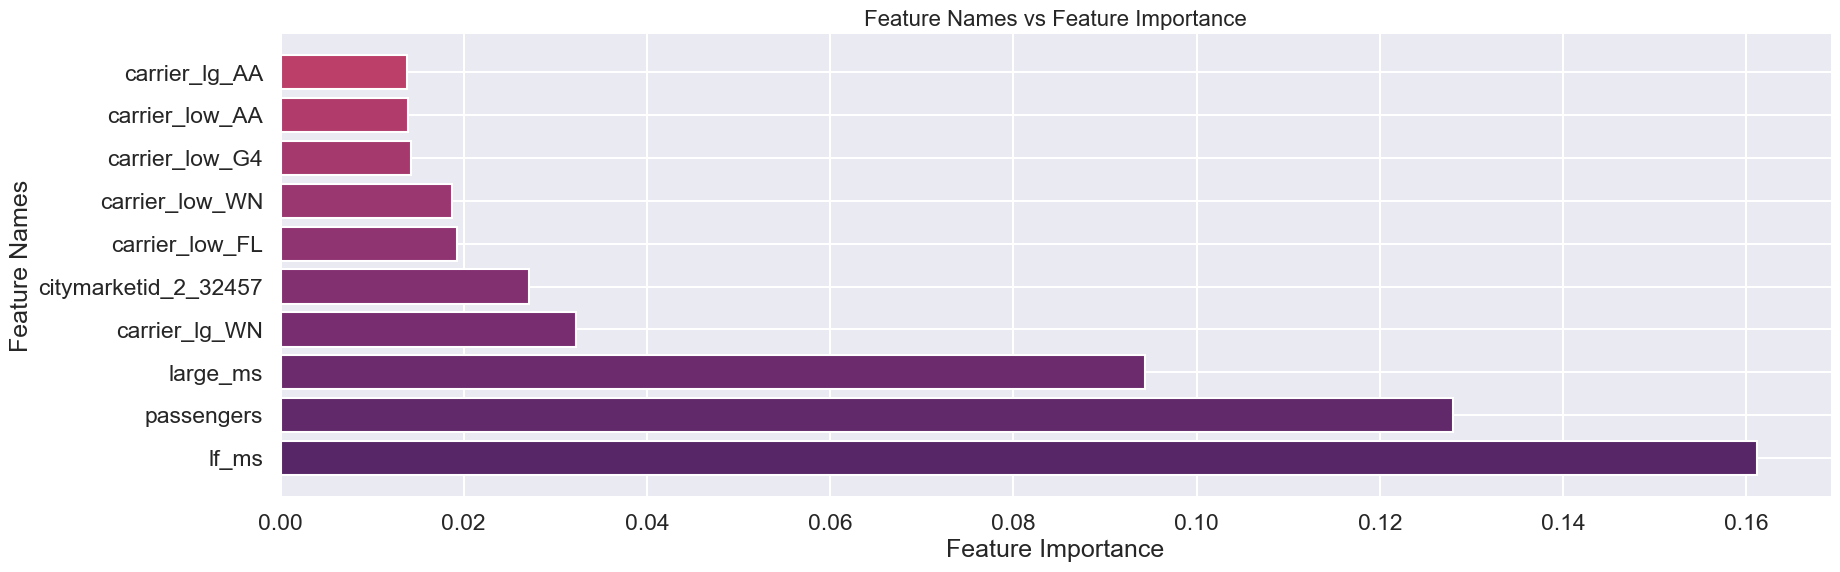

In [1277]:
# Plotting first 10 importance features
n = 10
importance_df = importance_df.sort_values("feature_importance", ascending=False)

fig, ax = plt.subplots(figsize=(20, 6))
ax.barh(importance_df["feature_name"][:n], importance_df["feature_importance"][:n], color=sns.color_palette())
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature Names')
ax.set_title('Feature Names vs Feature Importance', size=16)


fig.savefig(save_results_to + "FI_rf1_transparent.png", transparent=True)

fig.savefig(save_results_to + "FI_rf1.png")
plt.show()

In [1278]:
p_importance = permutation_importance(rf_model, X_test, y_test)

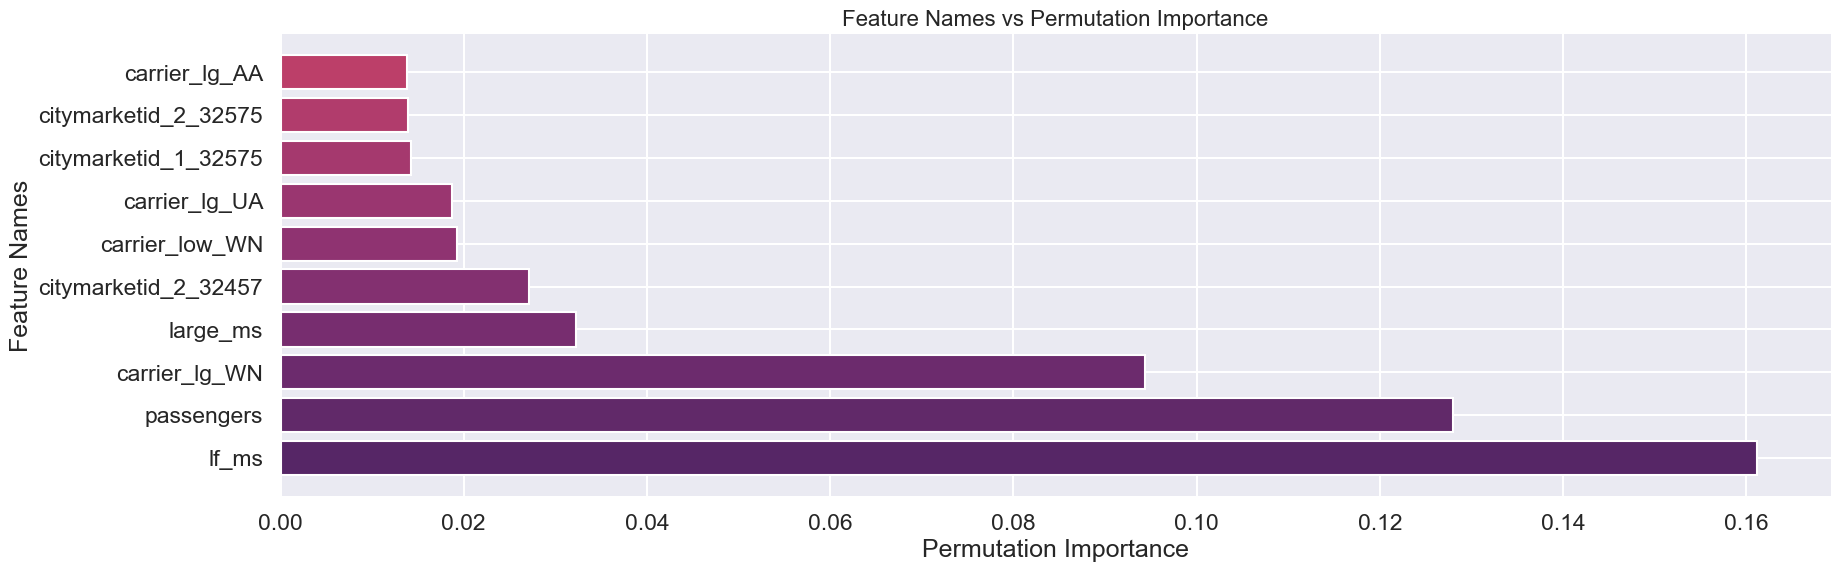

In [1279]:
p_importance_df = pd.DataFrame({"feature_name": rf_model.feature_names_in_, "feature_importance": p_importance["importances_mean"]})

p_importance_sorted = p_importance_df.sort_values("feature_importance", ascending=False)

fig, ax = plt.subplots(figsize=(20, 6))
ax.barh(p_importance_sorted["feature_name"][:n], importance_df["feature_importance"][:n], color=sns.color_palette())
ax.set_xlabel('Permutation Importance')
ax.set_ylabel('Feature Names')
ax.set_title('Feature Names vs Permutation Importance', size=16)

fig.savefig(save_results_to + "PI_rf1_transparent.png", transparent=True)
fig.savefig(save_results_to + "PI_rf1.png")


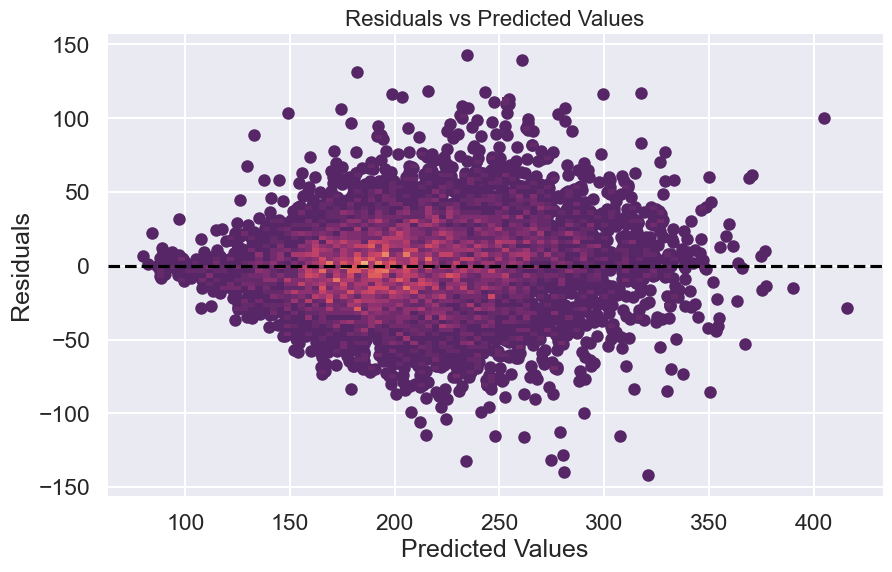

In [1280]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, color=sns.color_palette()[0], linewidth=0)
sns.histplot(x=y_pred, y=residuals, bins=100, pthresh=.01, cmap=theme)
# sns.kdeplot(x=y_pred, y=residuals, levels=5, color="w", linewidths=1)

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs Predicted Values', size=16)

# Add a horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--')

# Improve the plot
# ax.grid(True, linestyle=':', alpha=0.5)

fig.savefig(save_results_to + "residuals_rf1_transparent.png", transparent=True)
fig.savefig(save_results_to + "residuals_rf1.png")

plt.show()

#### Random Forest 2

The model is slightly overfit so we try to make the model less overfit by changing ```min_samples_split``` to 65

In [1281]:
rf_model2 = RandomForestRegressor(n_estimators=100, min_samples_split=65)

rf_model2.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=65)

In [1282]:
# R-squared scores
print("train:", rf_model2.score(X_train, y_train))

print("test:",rf_model2.score(X_test, y_test))

train: 0.7419420356532337
test: 0.6475767716322218


In [1283]:
# Compare train and test performance
train_mse = mean_squared_error(y_train, rf_model2.predict(X_train))
test_mse = mean_squared_error(y_test, rf_model2.predict(X_test))

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

train_rmse = root_mean_squared_error(y_train, rf_model2.predict(X_train))
test_rmse = root_mean_squared_error(y_test, rf_model2.predict(X_test))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train MSE: 877.3044829766858
Test MSE: 1162.0932307327287
Train RMSE: 29.619326173576024
Test RMSE: 34.089488566605525


In [1284]:
importance_df = pd.DataFrame({"feature_name": rf_model2.feature_names_in_, "feature_importance": rf_model2.feature_importances_})
display(importance_df)

,feature_name,feature_importance
0,passengers,0.104774
1,large_ms,0.068599
2,lf_ms,0.171387
3,quarter_1,0.001411
4,quarter_2,0.000561
...,...,...
311,carrier_low_WN,0.020367
312,carrier_low_XP,0.000089
313,carrier_low_YX,0.000048
314,table_1_flag_-1,0.006121


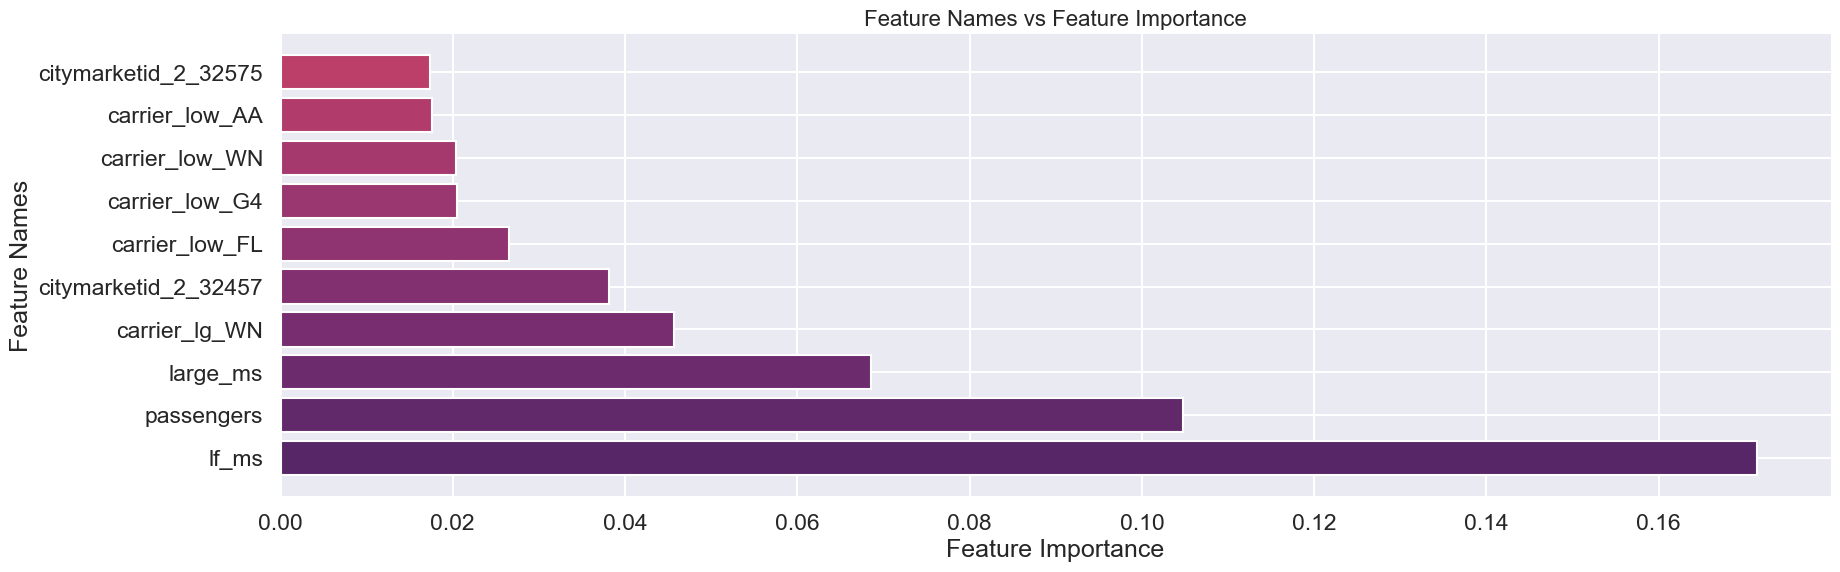

In [1285]:
# Plotting first 10 importance features
n = 10
importance_df = importance_df.sort_values("feature_importance", ascending=False)

fig, ax = plt.subplots(figsize=(20, 6))
ax.barh(importance_df["feature_name"][:n], importance_df["feature_importance"][:n], color=sns.color_palette())
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature Names')
ax.set_title('Feature Names vs Feature Importance', size=16)

fig.savefig(save_results_to + "FI_rf2_transparent.png", transparent=True)

fig.savefig(save_results_to + "FI_rf2.png")

plt.show()

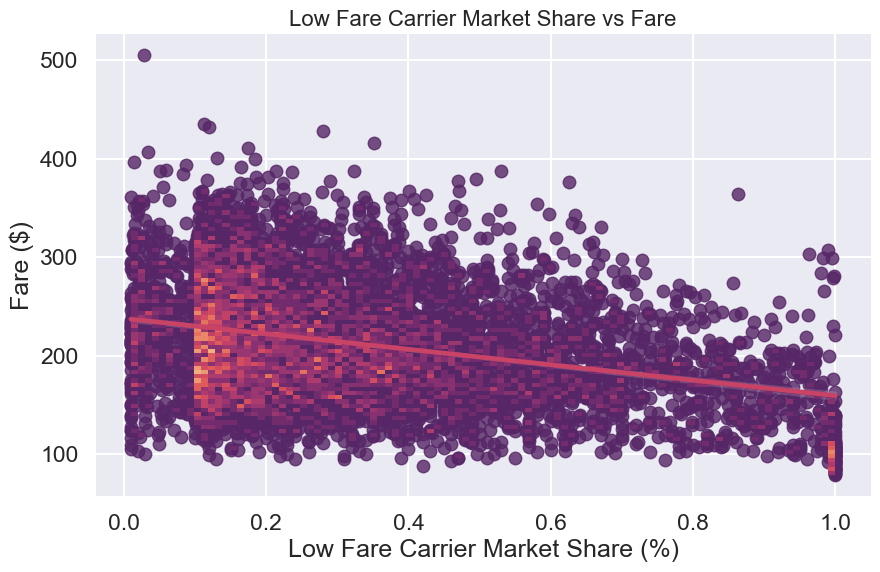

In [1286]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x=X_test["lf_ms"], y=y_test, line_kws = dict(color=sns.color_palette()[10]))
sns.histplot(x=X_test["lf_ms"], y=y_test, bins=100, pthresh=.01, cmap=theme)

ax.set_xlabel('Low Fare Carrier Market Share (%)')
ax.set_ylabel('Fare ($)')
ax.set_title('Low Fare Carrier Market Share vs Fare', size=16)

fig.savefig(save_results_to + "lf_ms_vs_fare_transparent.png", dpi=300, transparent=True)
fig.savefig(save_results_to + "lf_ms_vs_fare.png", dpi=300)
plt.show()

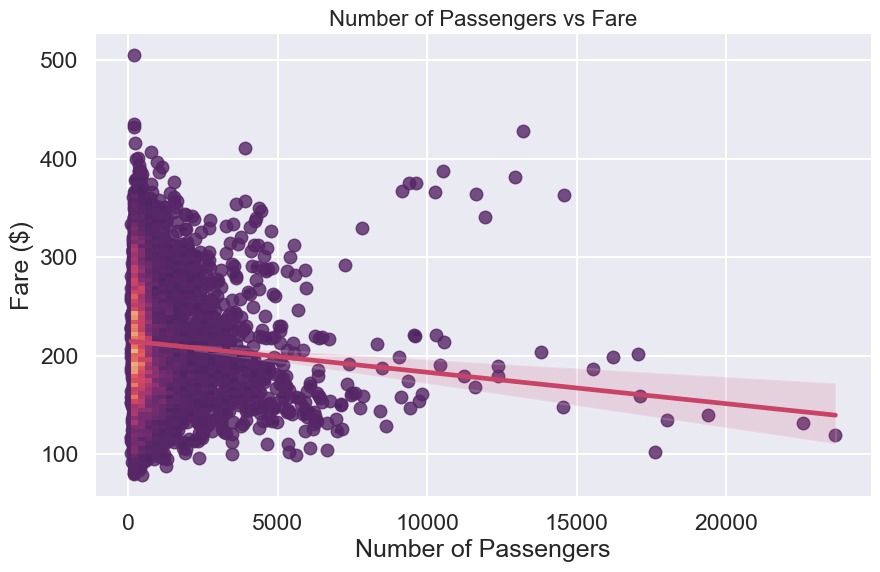

In [1287]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x=X_test["passengers"], y=y_test, line_kws = dict(color=sns.color_palette()[10]))
sns.histplot(x=X_test["passengers"], y=y_test, bins=100, pthresh=.01, cmap=theme)

ax.set_xlabel('Number of Passengers')
ax.set_ylabel('Fare ($)')
ax.set_title('Number of Passengers vs Fare', size=16)

fig.savefig(save_results_to + "pass_vs_fare_transparent.png", dpi=300, transparent=True)
fig.savefig(save_results_to + "pass_vs_fare.png", dpi=300)
plt.show()

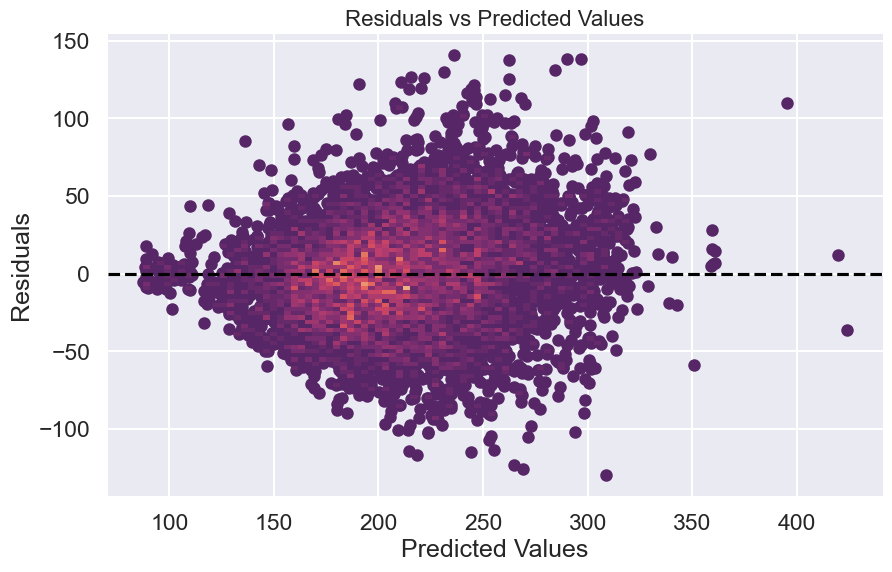

In [1288]:
# Make predictions
y_pred = rf_model2.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, color=sns.color_palette()[0], linewidth=0)
sns.histplot(x=y_pred, y=residuals, bins=100, pthresh=.01, cmap=theme)
# sns.kdeplot(x=y_pred, y=residuals, levels=5, color="w", linewidths=1)

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs Predicted Values', size=16)

# Add a horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--')

# Improve the plot
# ax.grid(True, linestyle=':', alpha=0.5)

fig.savefig(save_results_to + "residuals_rf2_transparent.png", dpi=300, transparent=True)
fig.savefig(save_results_to + "residuals_rf2.png", dpi=300)

plt.show()

#### XGBoost 1

In [1289]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

print("Train score:", model.score(X_train, y_train))
print("Test score:", model.score(X_test, y_test))

Train score: 0.7401233714006803
Test score: 0.6770486357933511


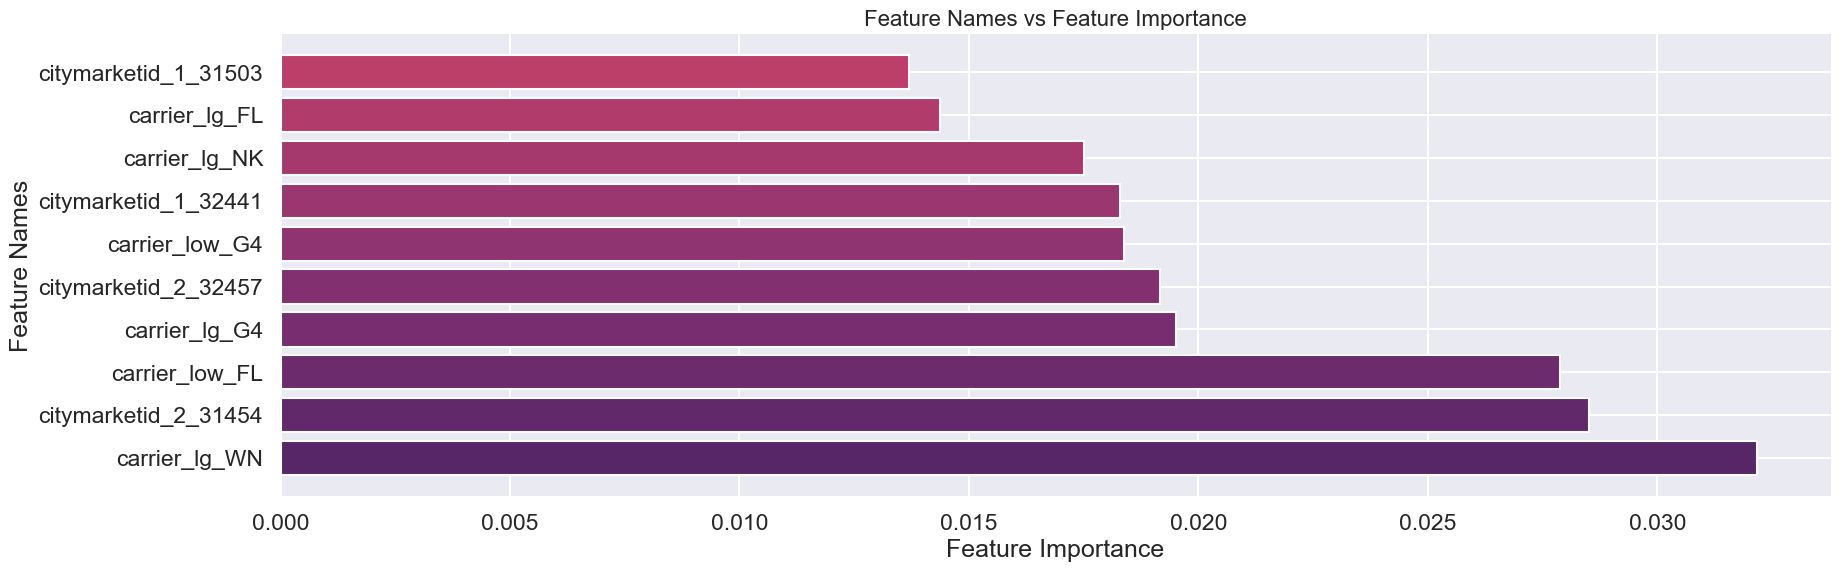

In [1290]:
importance_df = pd.DataFrame({"feature_name": model.feature_names_in_, "feature_importance": model.feature_importances_})

# Plotting first 10 importance features
n = 10
importance_df = importance_df.sort_values("feature_importance", ascending=False)

fig, ax = plt.subplots(figsize=(20, 6))
ax.barh(importance_df["feature_name"][:n], importance_df["feature_importance"][:n], color=sns.color_palette())
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature Names')
ax.set_title('Feature Names vs Feature Importance', size=16)

fig.savefig(save_results_to + "FI_xgboost1_transparent.png", dpi=300, transparent=True)

fig.savefig(save_results_to + "FI_xgboost1.png", dpi=300)

plt.show()

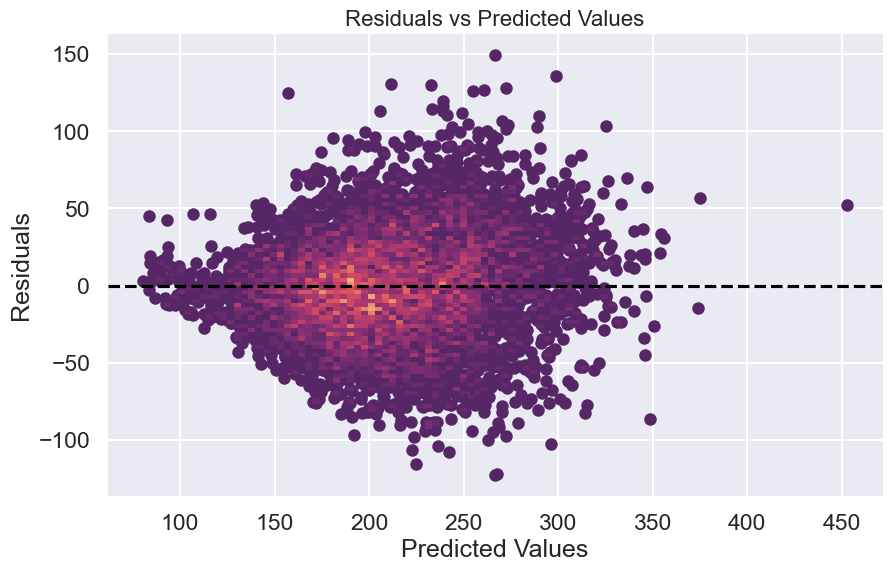

In [1291]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, color=sns.color_palette()[0], linewidth=0)
sns.histplot(x=y_pred, y=residuals, bins=100, pthresh=.01, cmap=theme)
# sns.kdeplot(x=y_pred, y=residuals, levels=5, color="w", linewidths=1)

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs Predicted Values', size=16)

# Add a horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--')

# Improve the plot
# ax.grid(True, linestyle=':', alpha=0.5)

fig.savefig(save_results_to + "residuals_xgboost1_transparent.png", transparent=True)
fig.savefig(save_results_to + "residuals_xgboost1.png")


### Elastic Net (L1 and L2 Regularization)

In [1292]:
model = ElasticNet()

# Fit the model
model.fit(X_train_normalized, y_train)

ElasticNet()

In [1293]:
# Make predictions
y_pred = model.predict(X_test_normalized)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

print("train score:", model.score(X_train_normalized, y_train))
print("test score:", model.score(X_test_normalized, y_test))

# Print model coefficients
# print("Model Coefficients:", model.coef_)
# print("Intercept:", model.intercept_)

Mean Squared Error: 3020.2804248758403
train score: 0.08331707309349023
test score: 0.08405199362566884


### Linear Regression

In [1294]:
# Create Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X_train_normalized, y_train)

LinearRegression()

In [1295]:
# Make predictions
y_pred = model.predict(X_test_normalized)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

print("Train score:", model.score(X_train_normalized, y_train))
print("Test score:", model.score(X_test_normalized, y_test))

Mean Squared Error: 6.130371930035628e+24
Train score: 0.4637838339331868
Test score: -1.859132649207606e+21


### Experiment 2

#### Random Forest 3

In [1296]:
rf_model3 = RandomForestRegressor(n_estimators=100)

rf_model3.fit(cr_X_train, cr_y_train)

RandomForestRegressor()

In [1297]:
# R-squared scores
print("train:", rf_model3.score(cr_X_train, cr_y_train))

print("test:",rf_model3.score(cr_X_test, cr_y_test))

train: 0.9424527168892749
test: 0.5900086504291013


In [1298]:
# Compare train and test performance
train_mse = mean_squared_error(cr_y_train, rf_model3.predict(cr_X_train))
test_mse = mean_squared_error(cr_y_test, rf_model3.predict(cr_X_test))

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

train_rmse = root_mean_squared_error(cr_y_train, rf_model3.predict(cr_X_train))
test_rmse = root_mean_squared_error(cr_y_test, rf_model3.predict(cr_X_test))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train MSE: 0.08009582983127352
Test MSE: 0.5775695826990117
Train RMSE: 0.28301206658245776
Test RMSE: 0.7599799883543064


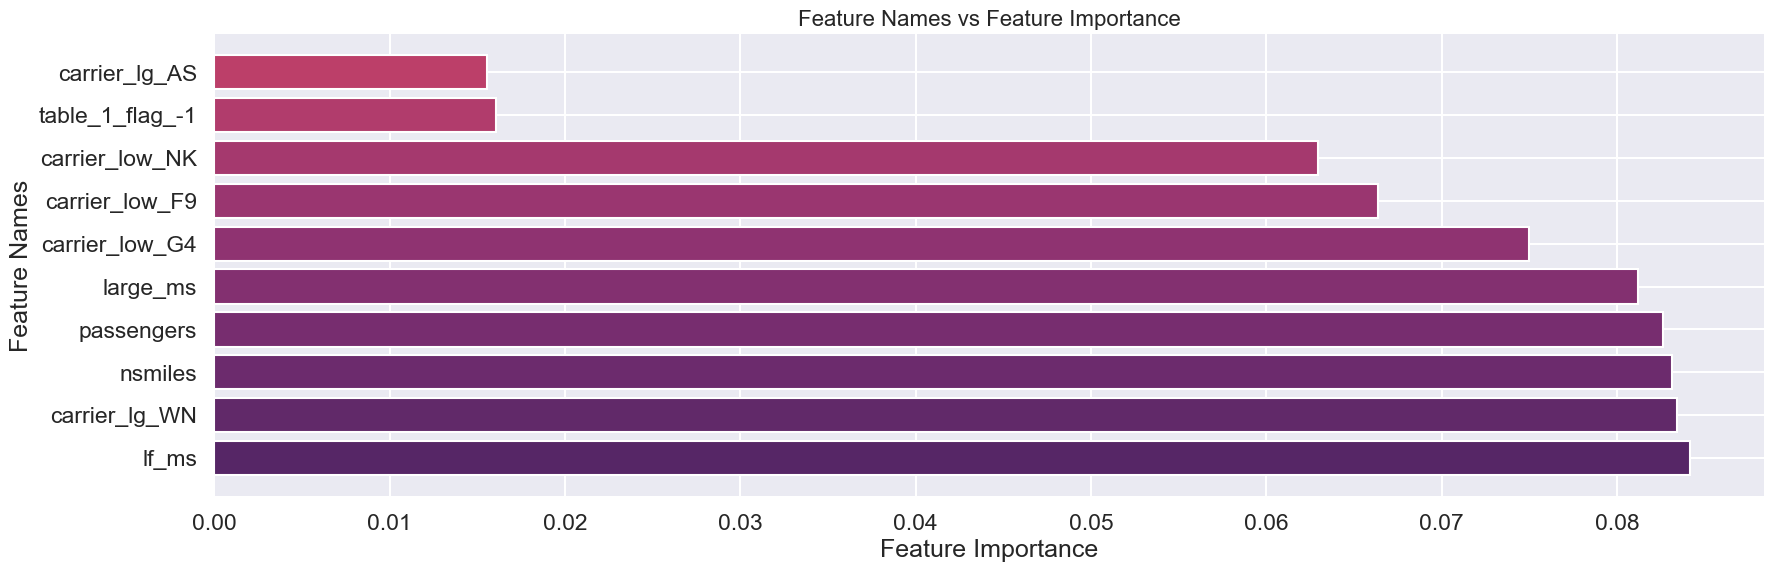

In [1299]:
# Plotting first 10 importance features
n = 10
importance_df = pd.DataFrame({"feature_name": rf_model3.feature_names_in_, "feature_importance": rf_model3.feature_importances_})
importance_df = importance_df.sort_values("feature_importance", ascending=False)

fig, ax = plt.subplots(figsize=(20, 6))
ax.barh(importance_df["feature_name"][:n], importance_df["feature_importance"][:n], color=sns.color_palette())
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature Names')
ax.set_title('Feature Names vs Feature Importance', size=16)

fig.savefig(save_results_to + "FI_xgboost2_transparent.png", dpi=300, transparent=True)

fig.savefig(save_results_to + "FI_xgboost2.png", dpi=300)

plt.show()

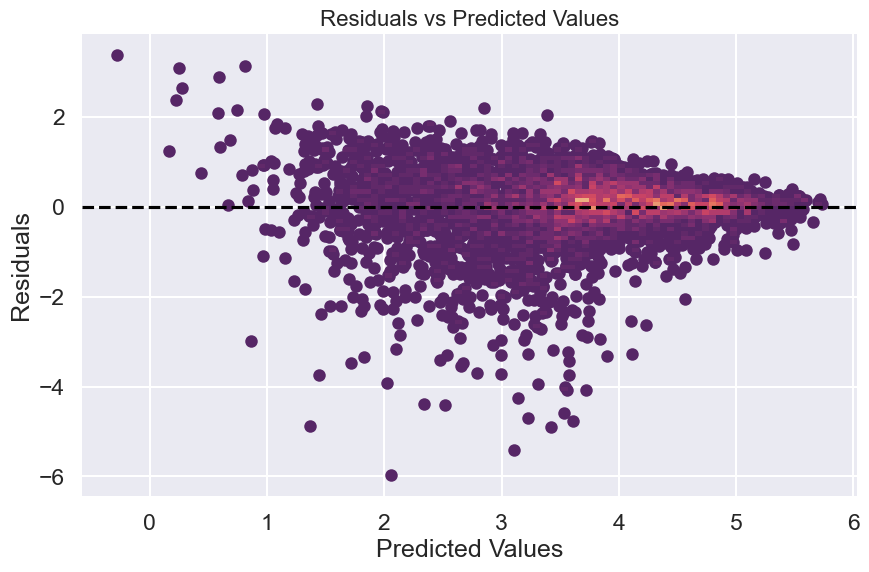

In [1300]:
# Make predictions
y_pred = rf_model3.predict(cr_X_test)

# Calculate residuals
residuals = cr_y_test - y_pred

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, color=sns.color_palette()[0], linewidth=0)
sns.histplot(x=y_pred, y=residuals, bins=100, pthresh=.01, cmap=theme)
# sns.kdeplot(x=y_pred, y=residuals, levels=5, color="w", linewidths=1)

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs Predicted Values', size=16)

# Add a horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--')

# Improve the plot
# ax.grid(True, linestyle=':', alpha=0.5)

fig.savefig(save_results_to + "residuals_rf3_transparent.png", dpi=300, transparent=True)
fig.savefig(save_results_to + "residuals2_rf3.png", dpi=300)

plt.show()

#### XGBoost 2

In [1301]:
model = xgb.XGBRegressor()
model.fit(cr_X_train, cr_y_train)

print("Train score:", model.score(cr_X_train, cr_y_train))
print("Test score:", model.score(cr_X_test, cr_y_test))

Train score: 0.7141987264771075
Test score: 0.5455242023097258


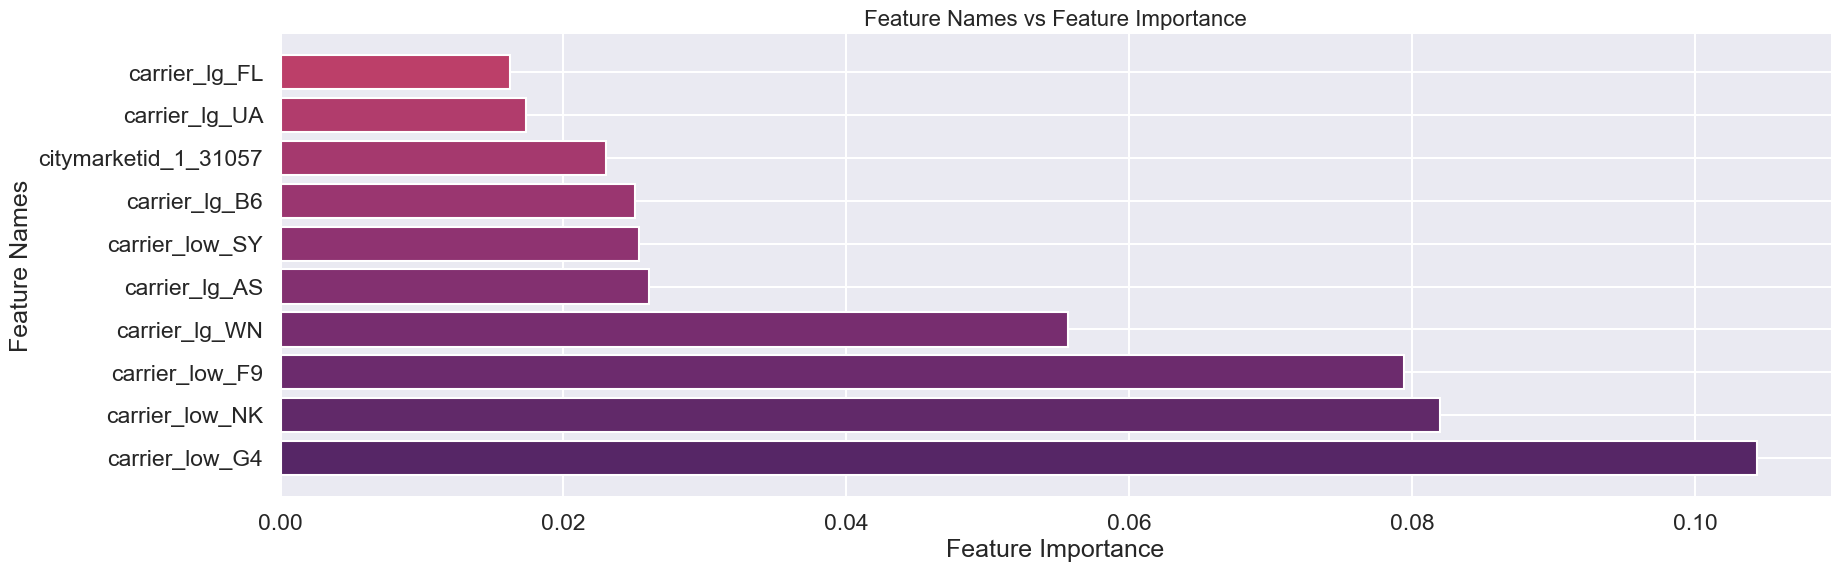

In [1302]:
importance_df = pd.DataFrame({"feature_name": rf_model3.feature_names_in_, "feature_importance": model.feature_importances_})

# Plotting first 10 importance features
n = 10
importance_df = importance_df.sort_values("feature_importance", ascending=False)

fig, ax = plt.subplots(figsize=(20, 6))
ax.barh(importance_df["feature_name"][:n], importance_df["feature_importance"][:n], color=sns.color_palette())
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature Names')
ax.set_title('Feature Names vs Feature Importance', size=16)

fig.savefig(save_results_to + "FI_xgboost2_transparent.png", dpi=300, transparent=True)

fig.savefig(save_results_to + "FI_xgboost2.png", dpi=300)

plt.show()

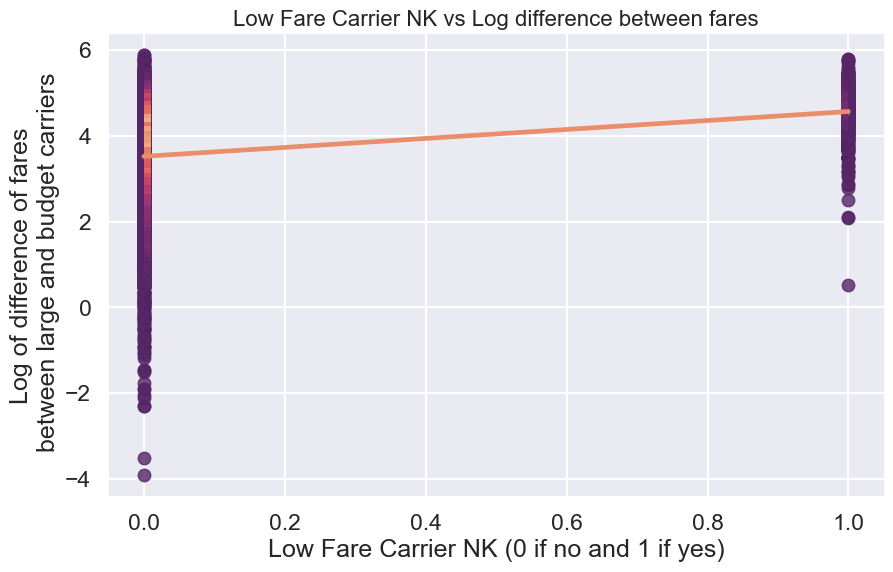

In [1314]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x=cr_X_test["carrier_low_NK"], y=cr_y_test, line_kws = dict(color=sns.color_palette()[-3]))
sns.histplot(x=cr_X_test["carrier_low_NK"], y=cr_y_test, bins=100, pthresh=.01, cmap=theme)

ax.set_xlabel('Low Fare Carrier NK (0 if no and 1 if yes)')
ax.set_ylabel('Log of difference of fares\n between large and budget carriers')
ax.set_title('Low Fare Carrier NK vs Log difference between fares', size=16)

fig.savefig(save_results_to + "LowFareNK_vs_log_diff_transparent.png", dpi=300, transparent=True)
fig.savefig(save_results_to + "LowFareNK_vs_log_diff_.png", dpi=300)
plt.show()

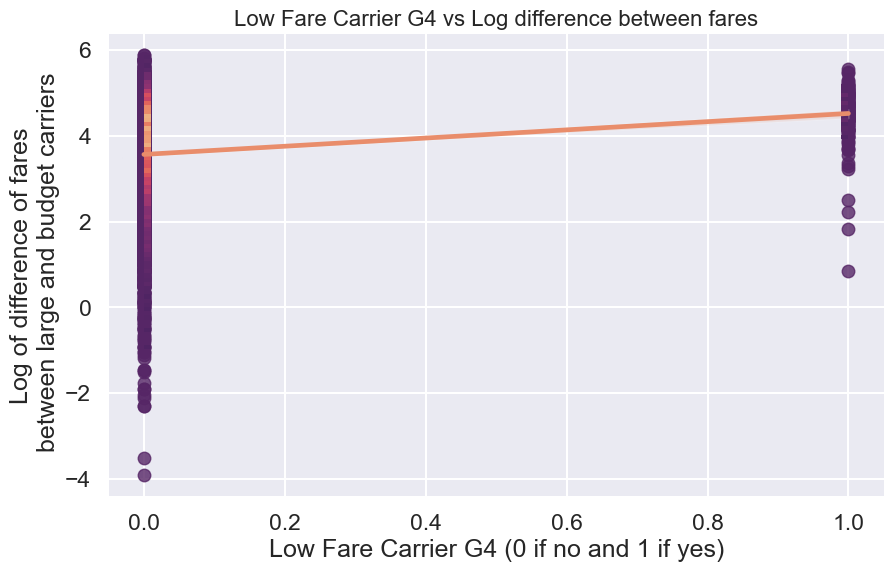

In [1315]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x=cr_X_test["carrier_low_G4"], y=cr_y_test, line_kws = dict(color=sns.color_palette()[-3]))
sns.histplot(x=cr_X_test["carrier_low_G4"], y=cr_y_test, bins=100, pthresh=.01, cmap=theme)

ax.set_xlabel('Low Fare Carrier G4 (0 if no and 1 if yes)')
ax.set_ylabel('Log of difference of fares\n between large and budget carriers')
ax.set_title('Low Fare Carrier G4 vs Log difference between fares', size=16)

fig.savefig(save_results_to + "LowFareG4_vs_log_diff_transparent.png", dpi=300, transparent=True)
fig.savefig(save_results_to + "LowFareG4_vs_log_diff_", dpi=300)
plt.show()

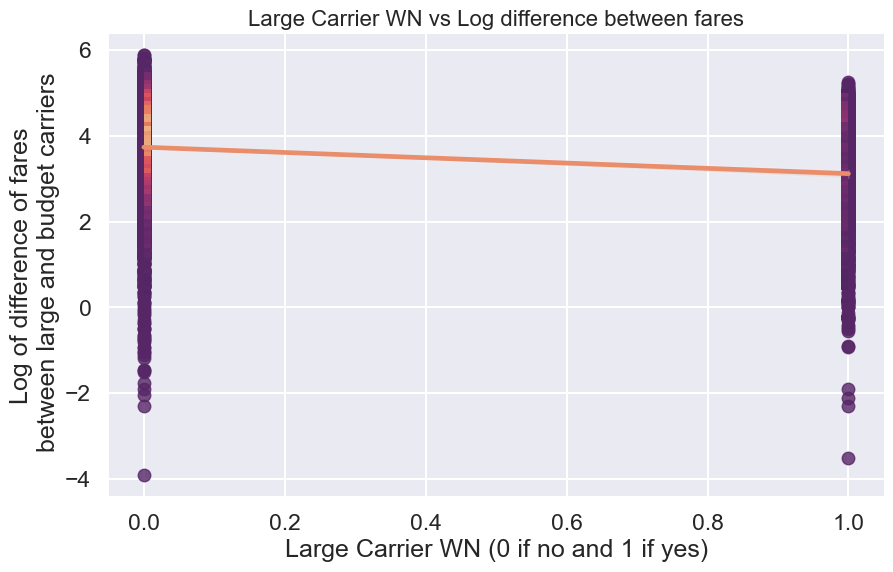

In [1316]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x=cr_X_test["carrier_lg_WN"], y=cr_y_test, line_kws = dict(color=sns.color_palette()[-3]))
sns.histplot(x=cr_X_test["carrier_lg_WN"], y=cr_y_test, bins=100, pthresh=.01, cmap=theme)

ax.set_xlabel('Large Carrier WN (0 if no and 1 if yes)')
ax.set_ylabel('Log of difference of fares\n between large and budget carriers')
ax.set_title('Large Carrier WN vs Log difference between fares', size=16)

fig.savefig(save_results_to + "LargeWN_vs_log_diff_transparent.png", dpi=300, transparent=True)
fig.savefig(save_results_to + "LargeWN_vs_log_diff_.png", dpi=300)
plt.show()

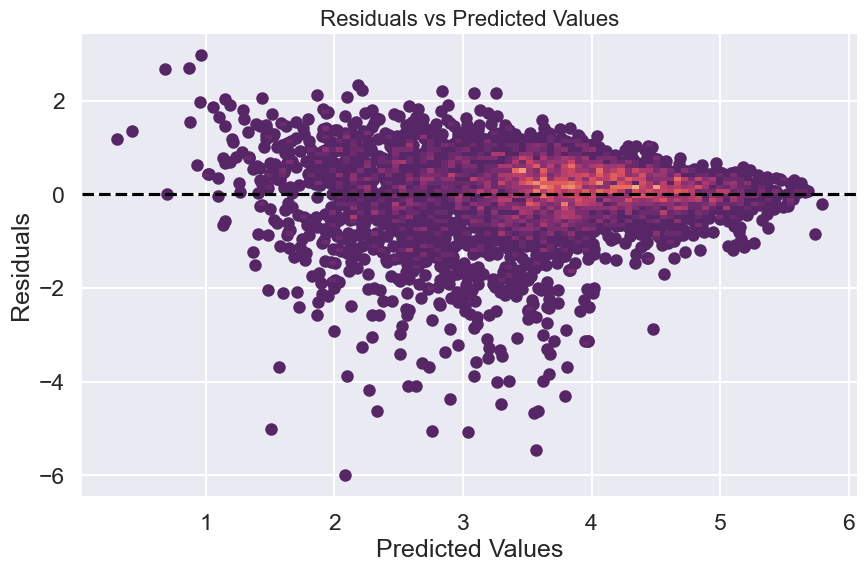

In [1305]:
# Make predictions
y_pred = model.predict(cr_X_test)

# Calculate residuals
residuals = cr_y_test - y_pred

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, color=sns.color_palette()[0], linewidth=0)
sns.histplot(x=y_pred, y=residuals, bins=100, pthresh=.01, cmap=theme)
# sns.kdeplot(x=y_pred, y=residuals, levels=5, color="w", linewidths=1)

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs Predicted Values', size=16)

# Add a horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--')

# Improve the plot
# ax.grid(True, linestyle=':', alpha=0.5)

fig.savefig(save_results_to + "residuals_xgboost2_transparent.png", transparent=True)
fig.savefig(save_results_to + "residuals_xgboost2.png")

plt.show()